In [1]:
!pip install numpy==1.23.4

In [1]:
!pip install keras_tuner
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer

import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree
from sklearn import tree

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lg
import xgboost as xg

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import scipy.stats as stats
import pylab

import shap
import re

from sklearn.feature_selection import mutual_info_regression

import lightgbm as lg
import xgboost as xg

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
import folium
from folium.plugins import MarkerCluster
from folium import plugins
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap

In [51]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

import itertools

import keras_tuner as kt
from keras_tuner import RandomSearch, HyperModel, BayesianOptimization, Hyperband
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf

### Functions

In [5]:
#################################
### Variance inflation factor ###
#################################

def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    return(vif)

In [6]:
##############################
### Min-Max transformation ###
##############################

def minmax_dset(dset,numeric_columns):

    dseta = dset.copy()
    dsetb = pd.DataFrame(transformer_train.transform(dseta[numeric_columns]))
    dsetb.columns = numeric_columns
    print(dsetb.shape)
    return dsetb

In [7]:
########################
### One hot encoding ###
########################

def ohe_dset(dset,categorical_columns):

    dseta = dset.copy()
    transformed_dset = ohe.fit_transform(dseta[categorical_columns])
    cat_data = pd.DataFrame(transformed_dset.toarray())
    cat_data.columns = ohe.get_feature_names_out(input_features=dseta[categorical_columns].columns)
    print(cat_data.shape)
    return cat_data

In [8]:
def get_rules(tree, feature_names, class_names, perc_thold = 80, sample_thold = 100):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]

    rules = []
    proba = []
    samples = []
    for path in paths:
        #print(path)
        rule = "if "

        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"

        if (np.round(100.0*classes[l]/np.sum(classes),2) > perc_thold) & (path[-1][1] > sample_thold):
            rules += [rule]
            proba += [np.round(100.0*classes[l]/np.sum(classes),2)]

    return rules, proba

In [9]:
class RegressionHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(
            Dense(
                units=hp.Int('units', 8, 64, 4, default=8),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                input_shape=input_shape
            )
        )

        model.add(
            Dense(
                units=hp.Int('units', 16, 64, 4, default=16),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')
            )
        )

        model.add(
            Dropout(
                hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.1,
                    default=0.005,
                    step=0.01)
            )
        )

        model.add(Dense(1))

        model.compile(
            optimizer='rmsprop',loss='mse',metrics=['mse']
        )

        return model

### Read in the data

In [10]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Change directory
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/New York City Airbnb Open Data")
# Print out the current directory
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/New York City Airbnb Open Data


In [11]:
df1 = pd.read_csv('AB_NYC_2019.csv', sep = ',')
df1 = df1.drop_duplicates()
print(df1.shape)
df1.head()

(48895, 16)


id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

#### Check on duplicate long/lat

In [ ]:
check = df1[['latitude','longitude']].drop_duplicates()
print(check.shape)

(48871, 2)


In [ ]:
c_loc = df1.groupby(['latitude','longitude'])['price'].count()
c_loc = c_loc.reset_index()
c_loc = c_loc.sort_values(['price'], ascending = False)
c_loc = c_loc[c_loc.price > 1]
print(c_loc.shape)

check = pd.merge(df1, c_loc, on = ['latitude','longitude'], how = 'inner')
#check

(23, 3)


In [ ]:
a = df1[df1.price > 1250]
print(a.shape)
#a.head()

(186, 16)


#### Check on minimum stay

In [ ]:
df1.minimum_nights.describe()

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [ ]:
check = df1[df1.minimum_nights > 365]
print(check.shape)
pd.crosstab(check.minimum_nights, columns = 'Count')

(14, 16)


col_0           Count
minimum_nights       
366                 1
370                 1
400                 1
480                 1
500                 5
999                 3
1000                1
1250                1

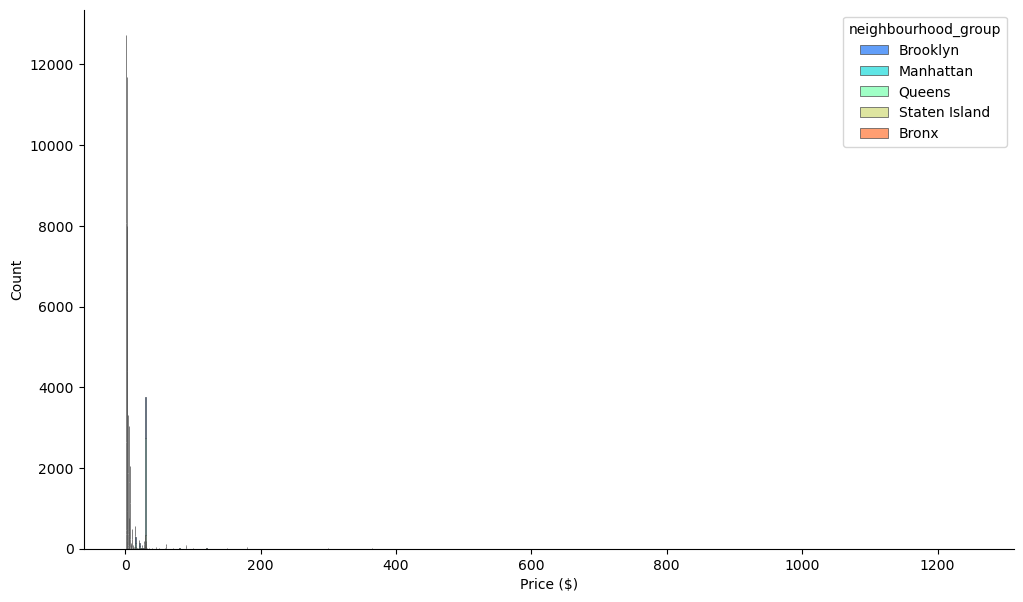

In [ ]:
f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

sns.histplot(
    df1,
    x="minimum_nights", hue="neighbourhood_group",
    multiple="stack",
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel("Minimum nights")
plt.show();

In [12]:
dfc = df1[~df1.last_review.isna()]
dfc.last_review = pd.to_datetime(dfc.last_review)
print(dfc.last_review.min(), dfc.last_review.max())

2011-03-28 00:00:00 2019-07-08 00:00:00



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Map data

In [ ]:
Long=-73.80
Lat=40.80

locations = list(zip(df1.latitude, df1.longitude))

map1 = folium.Map(location=[Lat,Long], zoom_start=9)

FastMarkerCluster(data=locations).add_to(map1)

map1

In [ ]:
m=folium.Map([40.7128,-74.0060],zoom_start=11)

HeatMap(df1[['latitude','longitude']].dropna(),radius=8,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(m)

display(m)

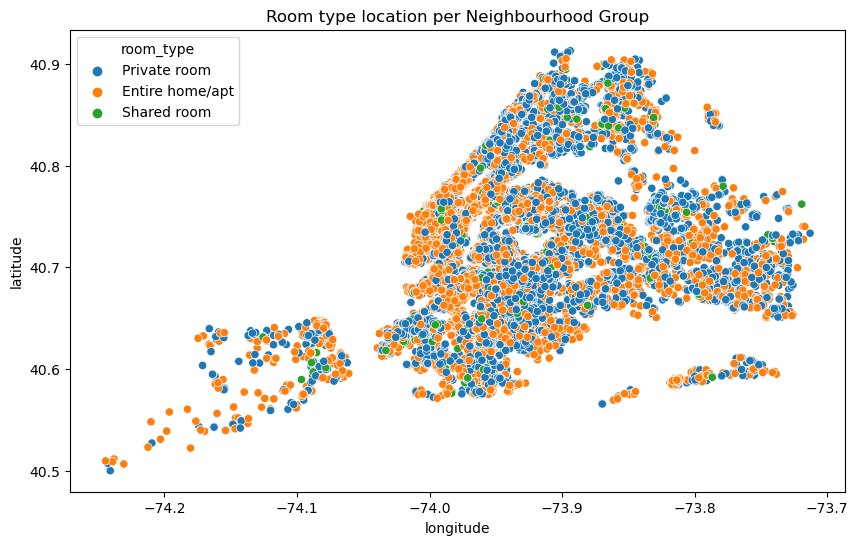

In [ ]:
title = 'Room type location per Neighbourhood Group'
plt.figure(figsize=(10,6))
sns.scatterplot(x='longitude', y='latitude', hue='room_type', data=df1).set_title(title)
plt.show()

In [ ]:
df1.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

<Figure size 1000x500 with 0 Axes>

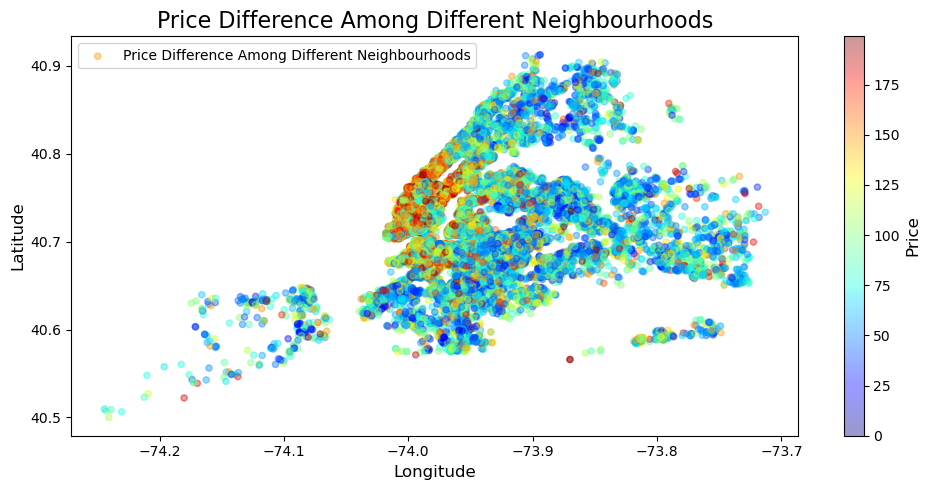

In [ ]:
df2 = df1[df1.price < 200]

plt.figure(figsize=(10, 5))

# Create the scatter plot
viz_4 = df2.plot(kind='scatter', x='longitude', y='latitude', label='Price Difference Among Different Neighbourhoods', c='price',
                cmap='jet', colorbar=True, alpha=0.4, figsize=(10, 5))

# Set plot title and labels
plt.title('Price Difference Among Different Neighbourhoods', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Adjust colorbar
colorbar = viz_4.collections[0].colorbar
colorbar.set_label('Price', fontsize=12)

# Show the plot
plt.legend()
plt.tight_layout()
plt.show();

### Adjust data

In [ ]:
#pd.crosstab(df.time_since.isnull(), columns = 'Count')

In [ ]:
#a = pd.crosstab(time_s, columns = 'Count')
#a = a.reset_index()
#a = a.sort_values(['Count'], ascending = False)
#a.head()
#a = pd.DataFrame(delat)
#a.median()[0]

In [13]:
df = df1.copy()
df = df[df.minimum_nights < 365]

df.calculated_host_listings_count = df.calculated_host_listings_count.astype(int)
df.loc[df.host_name.isna(),'host_name'] = 'Missing'
df.last_review = pd.to_datetime(df.last_review)

time_s = []
delat = []
for i in range(df.shape[0]):
    dset = df.iloc[i,:]
    if dset.last_review is pd.NaT:
        time_s.append('Missing')
    else:
        dset.last_review = pd.to_datetime(dset.last_review)
        delta = dfc.last_review.max() - dset.last_review
        time_s.append(str(delta.days))
        delat.append(delta.days)

a = pd.DataFrame(delat)

df['time_since'] = time_s
df.loc[df.time_since == 'Missing','time_since_miss'] = 0
df.loc[df.time_since != 'Missing','time_since_miss'] = 1
df.loc[df.time_since == 'Missing','time_since'] = int(a.median()[0])

for name in ['time_since_miss','time_since']:
    df[name] = df[name].astype(int)

for name in ['host_name', 'neighbourhood_group', 'neighbourhood', 'room_type']:
    df[name] = df[name].str.replace(r'-', r'_')
    df[name] = df[name].str.replace(r' ', r'_')
    df[name] = df[name].str.replace(r'/', r'')
    df[name] = df[name].str.replace(r',', r'')
    df[name] = df[name].str.replace(r'__', r'_')
    df[name] = df[name].str.replace(r"[\"\',]", '')
    df[name] = df[name].str.lstrip()
    df[name] = df[name].str.rstrip()

df.host_name = df.host_name.str.lower()

comp_lst = ['sonder_(nyc)','blueground']
hotel_lst = ['the_broome_hotel', 'hotel_vetiver', 'feather_factory_hotel', 'stewart_hotel', 'the_wagner_hotel', 'walker_hotel_greenwich_village', 'arthouse_hotel', 'hillside_hotel', 'hotel_mela', 'the_box_house_hotel', 'chamber_hotel', 'hudson_river_hotel', 'paramount_hotel', 'cassa_times_square_hotel', 'adria_hotel_&_conference_center']
apart_lst = ['the_mahogany_suite(studio_apartment', 'luxuryapartmentsbyamber', 'afi_apartments']
bb_lst = ['brooklyn&__breakfast___len_']
oth_lst = ['crny_monthly_rentals', 'lkl_rental','bridgestreet_corporate', 'corporate_housing']
df['company'] = 0
df.loc[df.host_name.isin(comp_lst + hotel_lst + apart_lst + bb_lst),'company'] = 1

df = df.drop(['id','last_review'], axis = 1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The default value of regex will change from True to False in a future version.


In [18]:
#pd.crosstab(df.gender,columns = 'Count')
print(list(df.columns))

['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'time_since', 'time_since_miss', 'company']


In [14]:
for i in range(df.shape[1]):
    print(f"The number of unique classes for {df.columns[i]} is {df.iloc[:,i].nunique()}")
    if df.iloc[:,i].nunique() < 15:
        print(f"    The classes are {df.iloc[:,i].unique()}")

The number of unique classes for name is 47866
The number of unique classes for host_id is 37420
The number of unique classes for host_name is 11411
The number of unique classes for neighbourhood_group is 5
    The classes are ['Brooklyn' 'Manhattan' 'Queens' 'Staten_Island' 'Bronx']
The number of unique classes for neighbourhood is 221
The number of unique classes for latitude is 19044
The number of unique classes for longitude is 14714
The number of unique classes for room_type is 3
    The classes are ['Private_room' 'Entire_homeapt' 'Shared_room']
The number of unique classes for price is 672
The number of unique classes for minimum_nights is 100
The number of unique classes for number_of_reviews is 394
The number of unique classes for reviews_per_month is 937
The number of unique classes for calculated_host_listings_count is 47
The number of unique classes for availability_365 is 366
The number of unique classes for time_since is 1763
The number of unique classes for time_since_mi

In [ ]:
df.head()

name  host_id    host_name  \
0                Clean & quiet apt home by the park     2787         John   
1                             Skylit Midtown Castle     2845     Jennifer   
2               THE VILLAGE OF HARLEM....NEW YORK !     4632    Elisabeth   
3                   Cozy Entire Floor of Brownstone     4869  LisaRoxanne   
4  Entire Apt: Spacious Studio/Loft by central park     7192        Laura   

  neighbourhood_group neighbourhood  latitude  longitude       room_type  \
0            Brooklyn    Kensington  40.64749  -73.97237    Private_room   
1           Manhattan       Midtown  40.75362  -73.98377  Entire_homeapt   
2           Manhattan        Harlem  40.80902  -73.94190    Private_room   
3            Brooklyn  Clinton_Hill  40.68514  -73.95976  Entire_homeapt   
4           Manhattan   East_Harlem  40.79851  -73.94399  Entire_homeapt   

   price  minimum_nights  number_of_reviews  reviews_per_month  \
0    149               1                  9               0.21   
1    225               1                 45               0.38   
2    150               3                  0                NaN   
3     89               1                270               4.64   
4     80              10                  9               0.10   

   calculated_host_listings_count  availability_365  time_since  \
0                               6               365         262   
1                               2               355          48   
2                               1               365          50   
3                               1               194           3   
4                               1                 0         231   

   time_since_miss  gender  
0                1  Person  
1                1  Person  
2                0  Person  
3                1  Person  
4                1  Person

### Missing data

In [ ]:
a = pd.DataFrame(df.isna().mean().round(4) * 100, columns = ['Count'])
a[a.Count > 0]

Count
name                0.03
reviews_per_month  20.56

### Target variable

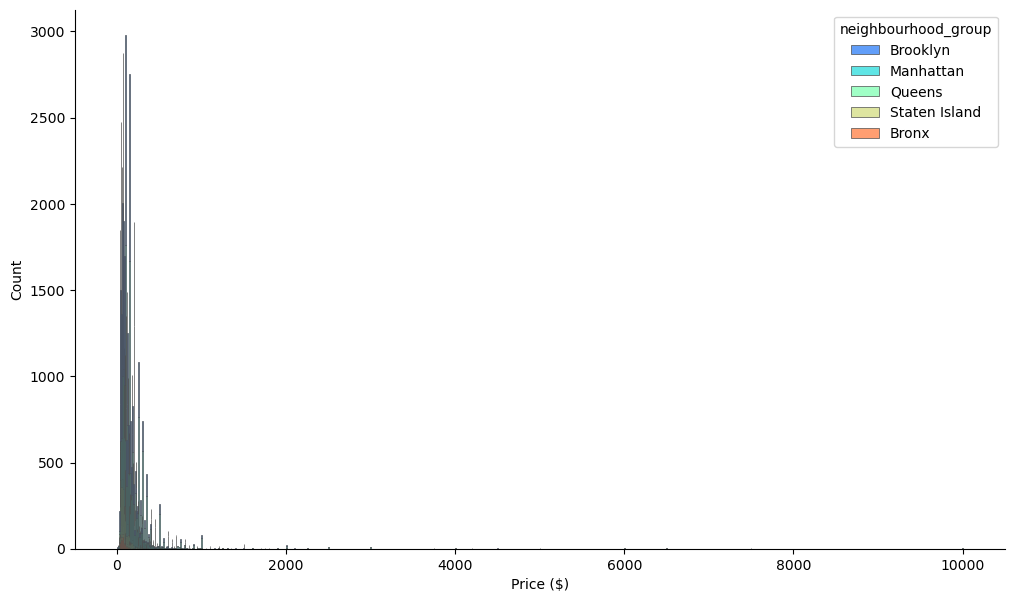

In [ ]:
f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

sns.histplot(
    df,
    x="price", hue="neighbourhood_group",
    multiple="stack",
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel("Price ($)")
plt.show();


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


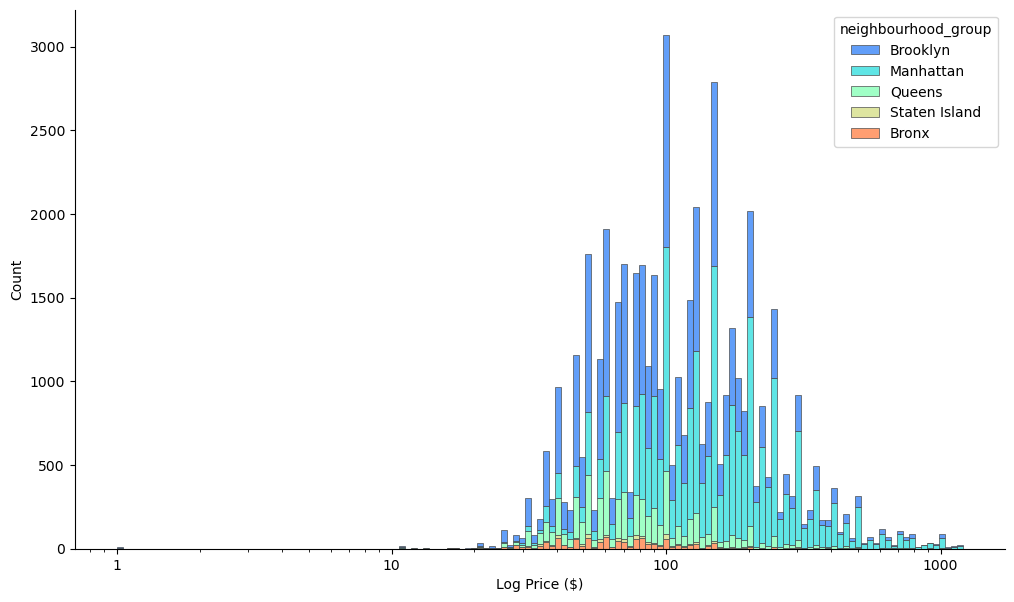

In [ ]:
dfa = df[df.price < 1250]
dfa.price = dfa.price + 1

f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

sns.histplot(
    dfa,
    x="price", hue="neighbourhood_group",
    multiple="stack",
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel("Log Price ($)")
plt.show();

### Graphs

#### Pie charts

In [ ]:
name = 'host_name'
c_loc = df.sort_values(by = name)
c_loc = c_loc.groupby([name])['price'].count()
c_loc = c_loc.reset_index()
c_loc['perc'] = c_loc['price']/df.shape[0] * 100
c_loc = c_loc.sort_values(by = 'perc', ascending = False)
c_loc['cum_perc'] = c_loc['perc'].cumsum()
c_loc = c_loc.reset_index(drop=True)
c_loca = c_loc[c_loc.cum_perc < 90]


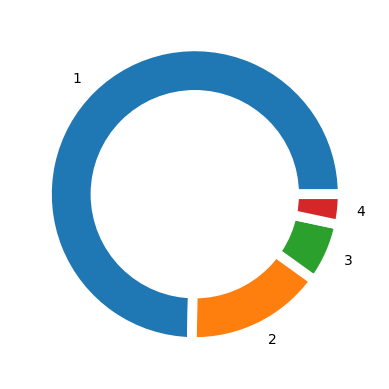

In [ ]:
name = 'calculated_host_listings_count'
c_loc = df.sort_values(by = name)
c_loc = c_loc.groupby([name])['price'].count()
c_loc = c_loc.reset_index()
c_loc['perc'] = c_loc['price']/df.shape[0] * 100
c_loc = c_loc.sort_values(by = 'perc', ascending = False)
c_loc['cum_perc'] = c_loc['perc'].cumsum()
c_loc = c_loc.reset_index(drop=True)
c_loca = c_loc[c_loc.cum_perc < 90]

my_circle = plt.Circle( (0,0), 0.7, color='white')

plt.pie(c_loca.perc, labels=c_loca[name], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
# c_loc[:20]

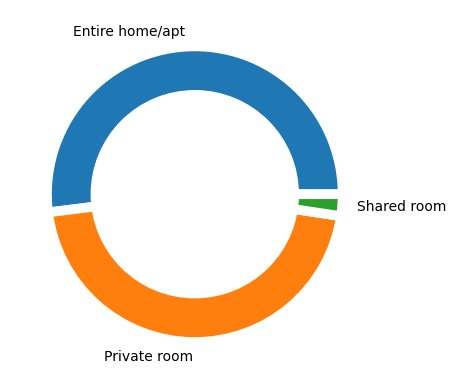

In [ ]:
name = 'room_type'
c_loc = df.sort_values(by = name)
c_loc = c_loc.groupby([name])['price'].count()
c_loc = c_loc.reset_index()
c_loc['perc'] = c_loc['price']/df.shape[0] * 100
c_loc = c_loc.sort_values(by = 'perc', ascending = False)
c_loc['cum_perc'] = c_loc['perc'].cumsum()
c_loc = c_loc.reset_index(drop=True)
#c_loca = c_loc[c_loc.cum_perc < 90]

my_circle = plt.Circle( (0,0), 0.7, color='white')

plt.pie(c_loc.perc, labels=c_loc[name], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()


In [ ]:
c_loc

room_type  price       perc    cum_perc
0  Entire home/apt  25409  51.966459   51.966459
1     Private room  22326  45.661111   97.627569
2      Shared room   1160   2.372431  100.000000

#### Scatter plots

In [ ]:
name = 'host_id'
host_id = df.groupby([name])['price'].count()
host_id = host_id.reset_index()
host_id_m = df.groupby([name])['price'].median()
host_id_m = host_id_m.reset_index()
host_id_a = pd.merge(host_id_m,host_id, on = 'host_id', how =  'left')
host_id_a.rename(columns = {'price_x':'Median price',
                            'price_y':'Count'}, inplace = True)


In [ ]:
host_id_a = host_id_a.sort_values(['Count'], ascending = False)
#host_id_a.head()
#df[df.host_id == 219517861]

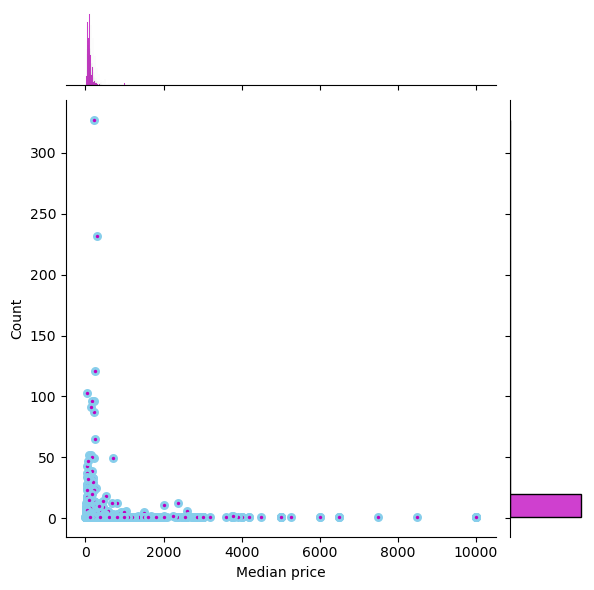

In [ ]:
#host_id_a = host_id_a[host_id_a.Count > 1]
ax = sns.jointplot(x=host_id_a['Median price'], y=host_id_a['Count'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
plt.show();

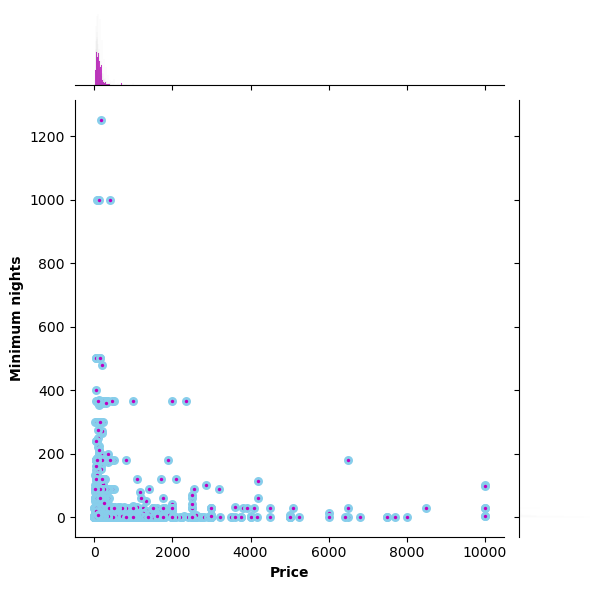

In [ ]:
ax = sns.jointplot(x=df['price'], y=df['minimum_nights'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
ax.ax_joint.set_xlabel('Price', fontweight='bold')
ax.ax_joint.set_ylabel('Minimum nights', fontweight='bold')
plt.show();

In [ ]:
df[df['minimum_nights'] > 100].shape

(174, 15)

#### Box plots

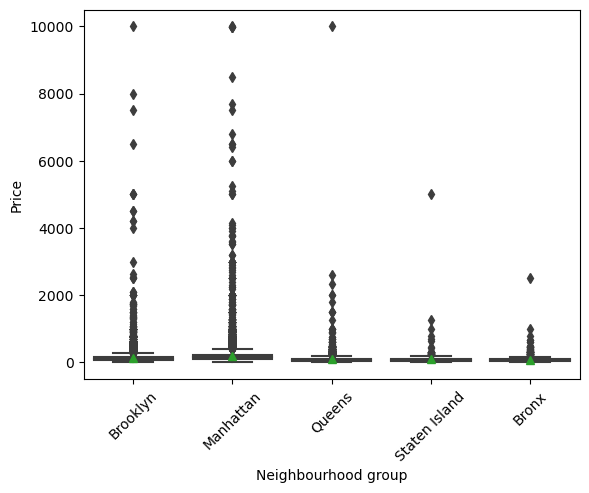

In [ ]:
sns.boxplot(data=df, x="neighbourhood_group", y="price", showmeans = True)
plt.xlabel("Neighbourhood group")
plt.xticks(rotation=45)
plt.ylabel("Price")
plt.show()

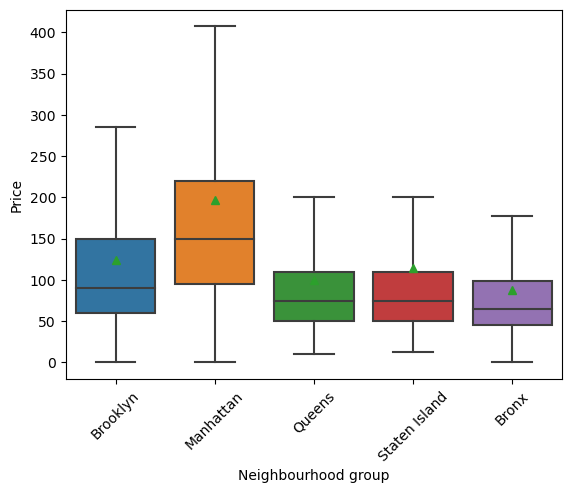

In [ ]:
sns.boxplot(data=df, x="neighbourhood_group", y="price", showfliers = False, showmeans = True)
plt.xlabel("Neighbourhood group")
plt.xticks(rotation=45)
plt.ylabel("Price")
plt.show()

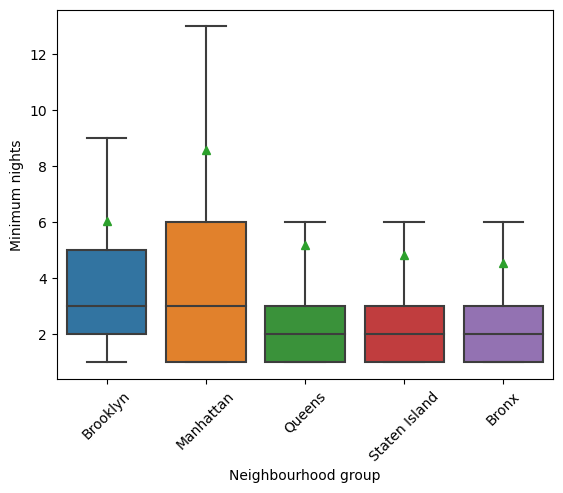

In [ ]:
sns.boxplot(data=df, x="neighbourhood_group", y="minimum_nights", showfliers = False, showmeans = True)
plt.xlabel("Neighbourhood group")
plt.xticks(rotation=45)
plt.ylabel("Minimum nights")
plt.show()

In [ ]:
name = 'neighbourhood'
c_loc = df.sort_values(by = name)
c_loc = c_loc.groupby([name])['price'].count()
c_loc = c_loc.reset_index()
c_loc['perc'] = c_loc['price']/df.shape[0] * 100
c_loc = c_loc.sort_values(by = 'perc', ascending = False)
c_loc['cum_perc'] = c_loc['perc'].cumsum()
c_loc = c_loc.reset_index(drop=True)
c_loca = c_loc[c_loc.cum_perc < 80]

c_locb = c_loca[:20]

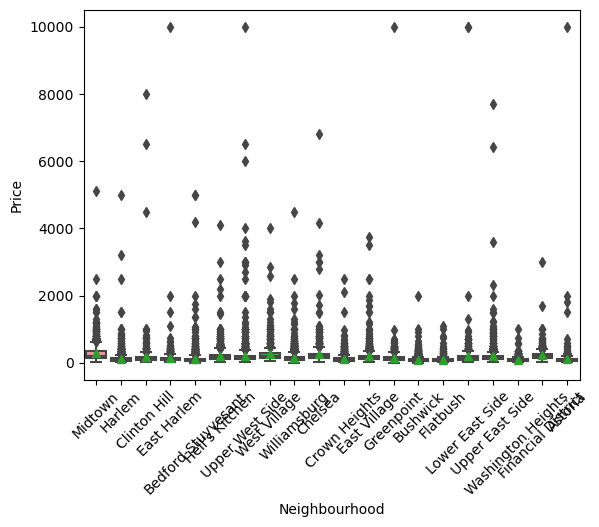

In [ ]:
n_df = df[df.neighbourhood.isin(list(c_locb.neighbourhood))]
sns.boxplot(data=n_df, x="neighbourhood", y="price", showmeans = True)
plt.xlabel("Neighbourhood")
plt.xticks(rotation=45)
plt.ylabel("Price")
plt.show()

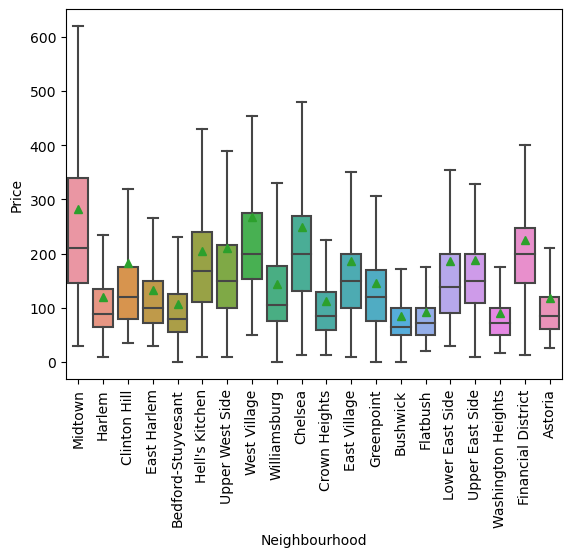

In [ ]:
sns.boxplot(data=n_df, x="neighbourhood", y="price", showmeans = True, showfliers = False)
plt.xlabel("Neighbourhood")
plt.xticks(rotation=90)
plt.ylabel("Price")
plt.show()

#### Rel plots

In [ ]:
# room_type_Entire_homeapt            0.290289
# room_type_Private_room              0.249939
# calculated_host_listings_count      0.157652
# neighbourhood_group_Manhattan       0.074881
# minimum_nights                      0.049430
# availability_365                    0.035308
# neighbourhood_group_Brooklyn        0.028105
# time_since                          0.028033

In [ ]:
print(list(df.columns))

['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


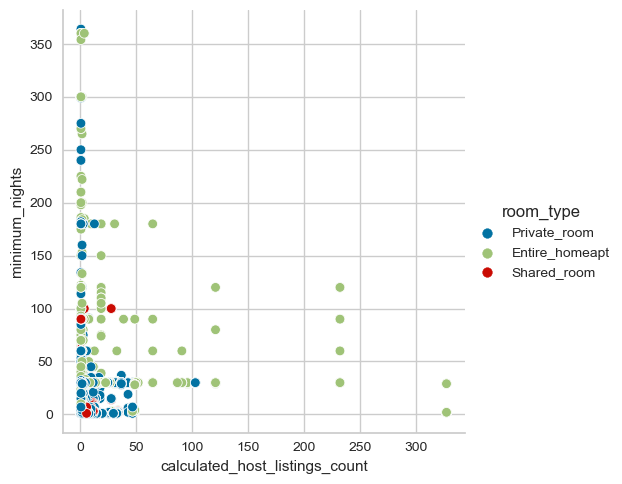

In [ ]:
sns.relplot(x='calculated_host_listings_count',
            y='minimum_nights',
            data=df,
            kind='scatter',
            hue='room_type');
plt.show();

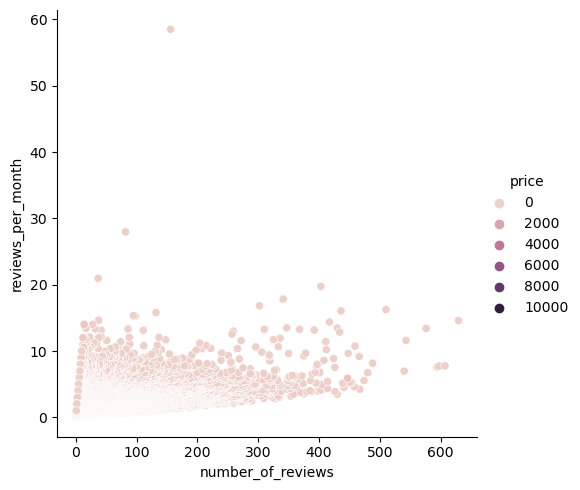

In [ ]:
dfz = df[~df.last_review.isna()]
sns.relplot(x='number_of_reviews',
            y='reviews_per_month',
            data=dfz,
            kind='scatter',
            hue='price');
plt.show();

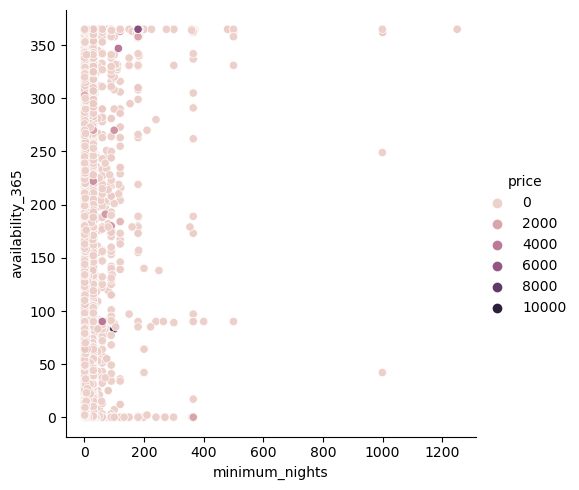

In [ ]:
sns.relplot(x='minimum_nights',
            y='availability_365',
            data=df,
            kind='scatter',
            hue='price');
plt.show();

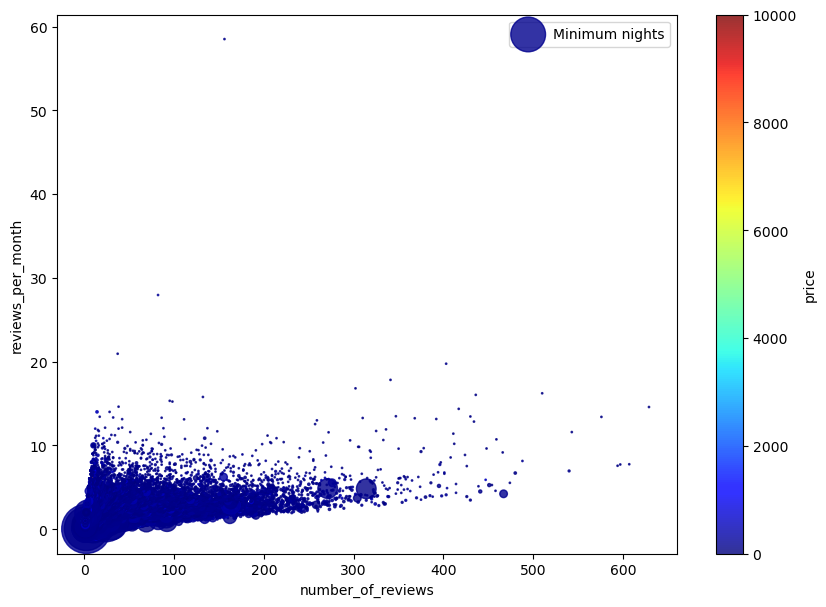

In [ ]:
dfz.plot(kind="scatter", x="number_of_reviews", y="reviews_per_month", alpha=0.8,
             s=dfz["minimum_nights"], label="Minimum nights", figsize=(10,7),
             c="price", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
plt.show()

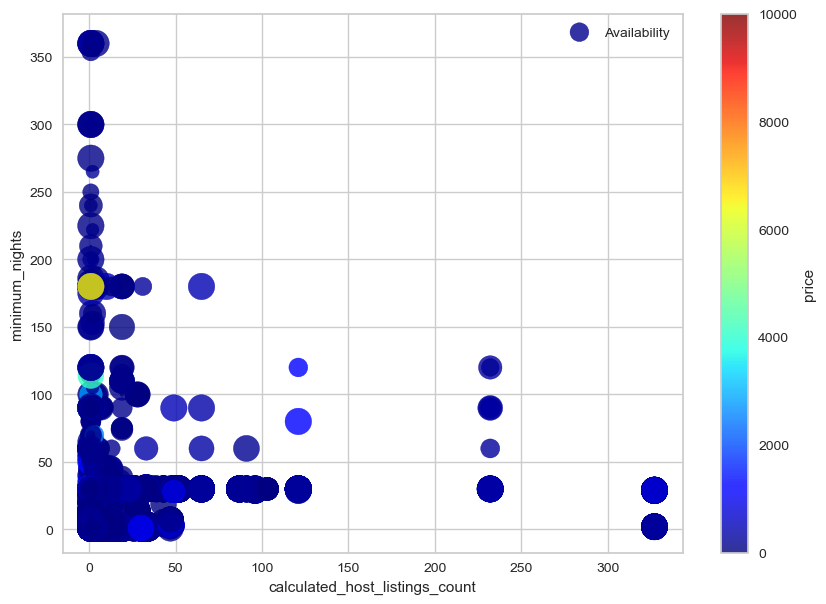

In [ ]:
df.plot(kind="scatter", x="calculated_host_listings_count", y="minimum_nights", alpha=0.8,
             s=df["availability_365"], label="Availability", figsize=(10,7),
             c="price", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
plt.show();

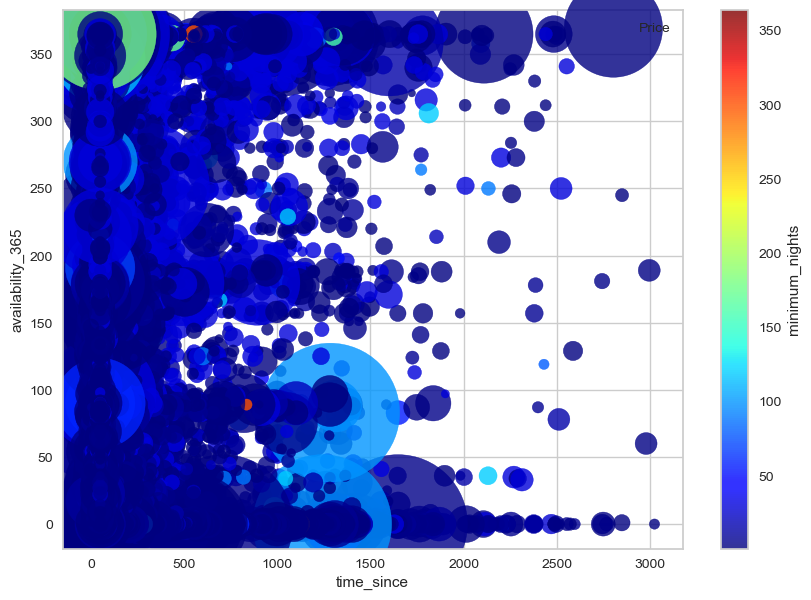

In [ ]:
df.plot(kind="scatter", x="time_since", y="availability_365", alpha=0.8,
             s=df["price"], label="Price", figsize=(10,7),
             c="minimum_nights", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
plt.show();

#### Line plot

In [ ]:
c_loc = df.groupby(['neighbourhood_group','last_review'])['price'].median()
c_loc = c_loc.reset_index()
c_loc.last_review = pd.to_datetime(c_loc.last_review)
#c_loc.head()

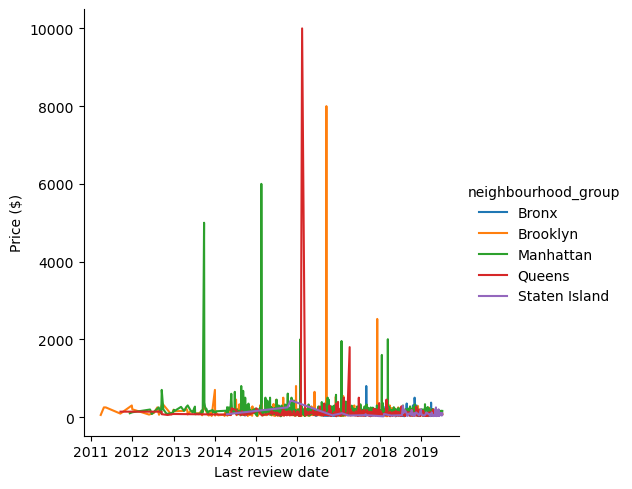

In [ ]:
sns.relplot(x='last_review',
            y='price',
            data=c_loc,
            kind='line',
            hue='neighbourhood_group')
plt.ylabel("Price ($)")
plt.xlabel("Last review date")
plt.show();

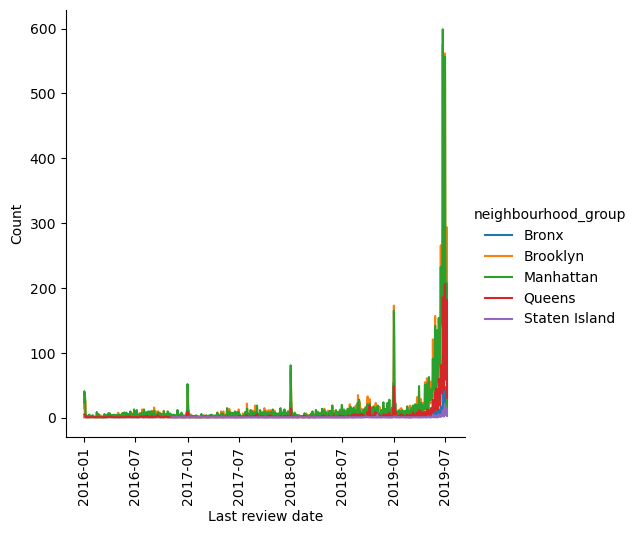

In [ ]:
c_loc = df.groupby(['neighbourhood_group','last_review'])['price'].count()
c_loc = c_loc.reset_index()
c_loc.last_review = pd.to_datetime(c_loc.last_review)
c_loc = c_loc[c_loc.last_review.dt.year > 2015]

sns.relplot(x='last_review',
            y='price',
            data=c_loc,
            kind='line',
            hue='neighbourhood_group')
plt.ylabel("Count")
plt.xlabel("Last review date")
plt.xticks(rotation=90)
plt.show();

#### Heat maps

In [ ]:
print(list(df.columns))

['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


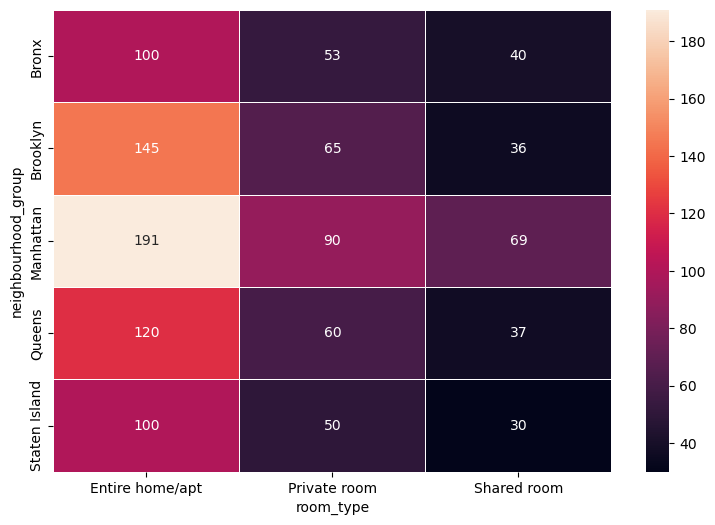

In [ ]:
data_a = df.groupby(['neighbourhood_group','room_type'])['price'].median()
data_a = data_a.reset_index()
data_a = data_a.pivot("neighbourhood_group","room_type", "price")
data_a.head()

for i in range(data_a.shape[1]):
    data_a.iloc[:,i] = data_a.iloc[:,i].fillna(0)
    data_a.iloc[:,i] = data_a.iloc[:,i].astype(int)

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_a, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.show();

#### Compare plot

In [ ]:
#df.head()

In [ ]:
dfd = df[df.neighbourhood_group == 'Manhattan']
data_b = dfd.groupby(['neighbourhood','room_type'])['price'].median()
data_b = data_b.reset_index()
data_c = data_b
data_c = data_c.pivot('neighbourhood','room_type', "price")
data_c = data_c.reset_index()
data_c = data_c.sort_values("neighbourhood", ascending=True)
data_c.head()
for name in ['Entire_homeapt','Private_room','Shared_room']:
    data_c.loc[:,name] = data_c.loc[:,name].fillna(0)
    data_c.loc[:,name] = data_c.loc[:,name].astype(int)


In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


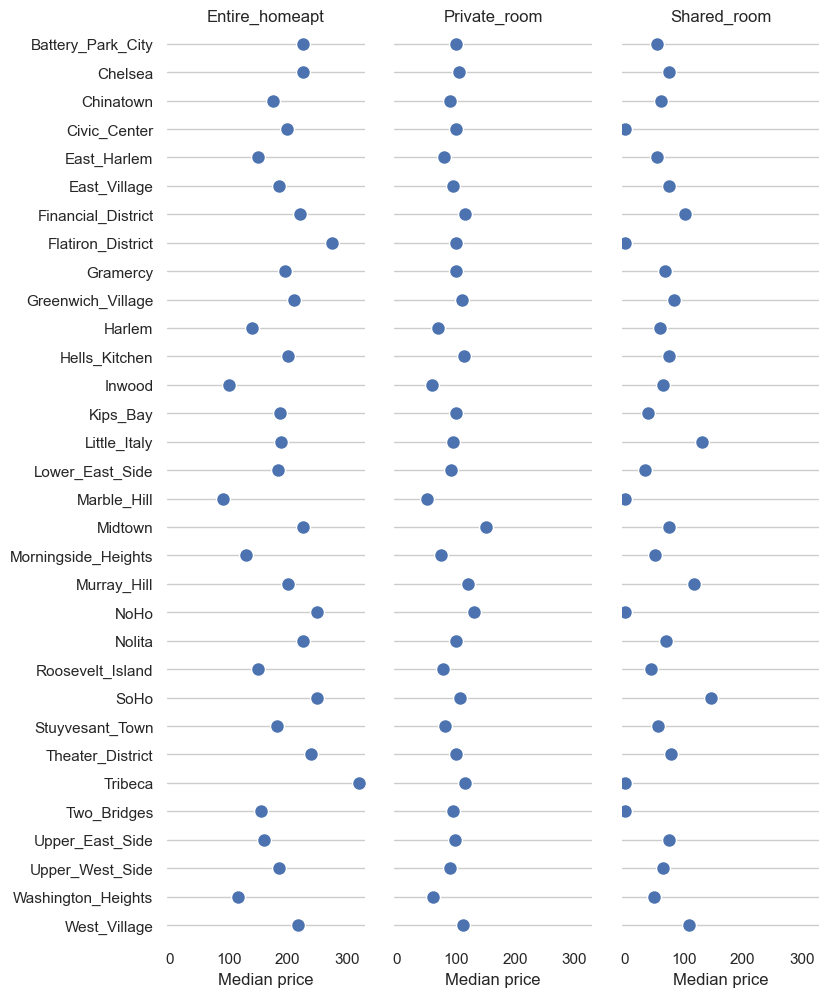

In [ ]:
sns.set_theme(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(data_c,
                 x_vars=data_c.columns[1:], y_vars=["neighbourhood"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-5, max(data_c.max(axis = 1)) + 10), xlabel="Median price", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['Entire_homeapt','Private_room','Shared_room']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [ ]:
data_a = df.groupby(['host_name'])['price'].count()
data_a = data_a.reset_index()
data_a = data_a.sort_values(['price'], ascending = False)
data_a = data_a.iloc[:20,:]
print(list(set(data_a.host_name)))

(48895, 17)
['alex', 'emily', 'jennifer', 'anna', 'james', 'andrew', 'daniel', 'jessica', 'sonder_(nyc)', 'laura', 'sarah', 'david', 'blueground', 'michael', 'melissa', 'maria', 'john', 'chris', 'mike', 'rachel']


In [ ]:
dfd = df[df.host_name.isin(list(set(data_a.host_name)))]
data_b = dfd.groupby(['host_name','neighbourhood_group'])['price'].median()
data_b = data_b.reset_index()
data_c = data_b
data_c = data_c.pivot('host_name','neighbourhood_group', "price")
data_c = data_c.reset_index()
data_c = data_c.sort_values("host_name", ascending=True)

for name in ['Bronx','Brooklyn','Manhattan','Queens','Staten_Island']:
    data_c.loc[:,name] = data_c.loc[:,name].fillna(0)
    data_c.loc[:,name] = data_c.loc[:,name].astype(int)


In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


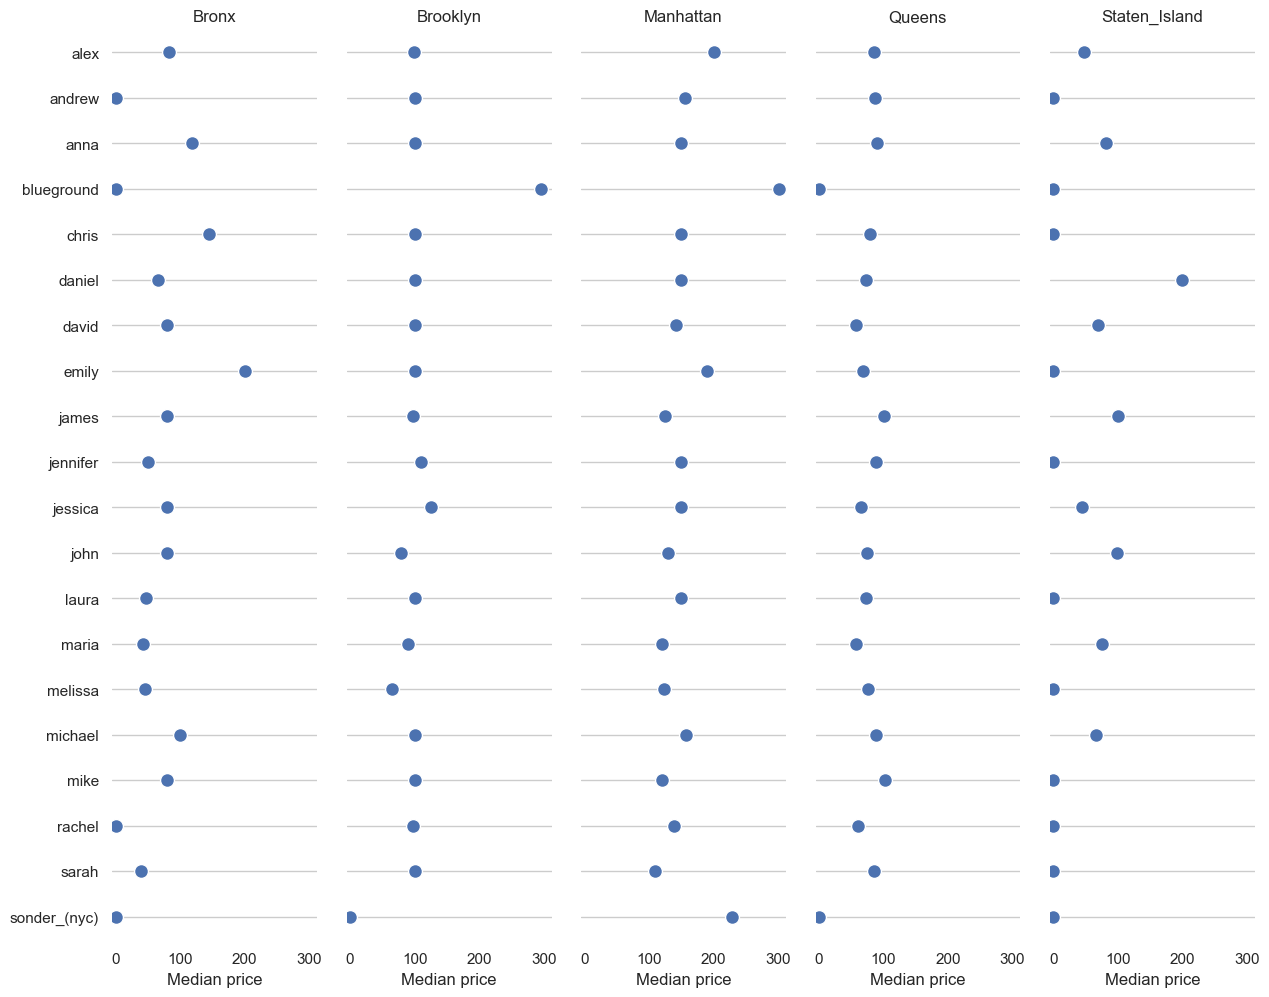

In [ ]:
sns.set_theme(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(data_c,
                 x_vars=data_c.columns[1:], y_vars=["host_name"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-5, max(data_c.max(axis = 1)) + 10), xlabel="Median price", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['Bronx','Brooklyn','Manhattan','Queens','Staten_Island']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

### New features

In [15]:
for name in ['feature_1','feature_2','feature_3','feature_4','feature_5','feature_6',
             'feature_7','feature_8','feature_9','feature_10','feature_11']:
    df[name] = 0
df.loc[((df['calculated_host_listings_count'] < 150) & (df.minimum_nights <= 200)),'feature_1'] = 1
df.loc[(df.availability_365 > 50) &
       (df.availability_365 < 320) &
       (df.time_since >= 750) &
       (df.minimum_nights < 150),'feature_2'] = 1
df.loc[(df.calculated_host_listings_count == 1) & (df.host_name == 'sarah'),'feature_3'] = 1
df.loc[(df.calculated_host_listings_count > 2) &
       (df.neighbourhood != 'Other') &
       (df.company == 1),'feature_4'] = 1
df.loc[(df.calculated_host_listings_count == 1) &
       (df.host_name.isin(['andrew','jennifer','melissa','mike','rachel'])),'feature_5'] = 1

df.loc[(df.room_type != 'Entire_homeapt') &
       (df.neighbourhood != 'Midtown') &
       (df.neighbourhood_group != 'Manhattan') &
       (~df.host_name.isin(['the_box_house_hotel','ana_y_victor'])),'feature_6'] = 1
df.loc[(df.room_type == 'Entire_homeapt') &
       (~df.neighbourhood.isin(['Washington_Heights','Inwood'])) &
       (df.neighbourhood_group == 'Manhattan') &
       (~df.host_name.isin(['carolann'])),'feature_7'] = 1
df.loc[(df.room_type != 'Entire_homeapt') &
       (~df.neighbourhood.isin(['Midtown','Hells_Kitchen'])) &
       (df.neighbourhood_group == 'Manhattan') &
       (df.availability_365 < 361),'feature_8'] = 1
df.loc[(df.room_type == 'Entire_homeapt') &
       (~df.neighbourhood_group.isin(['Brooklyn','Manhattan'])) &
       (df.availability_365 > 83),'feature_9'] = 1
df.loc[(df.room_type == 'Entire_homeapt') &
       (df.neighbourhood_group == 'Brooklyn') &
       (df.neighbourhood_group != 'Manhattan') &
       (~df.neighbourhood.isin(['Flatbush','Bensonhurst'])),'feature_10'] = 1
df.loc[(df.room_type != 'Entire_homeapt') &
       (df.neighbourhood.isin(['Midtown'])) &
       (df.room_type != 'Shared_room') &
       ((df.number_of_reviews < 14) | (df.number_of_reviews > 24)) &
       (~df.host_name.isin(['michel_fabrice'])),'feature_11'] = 1

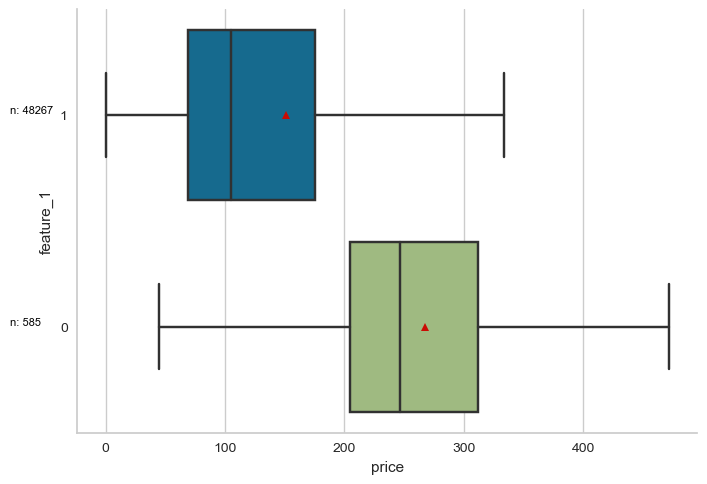

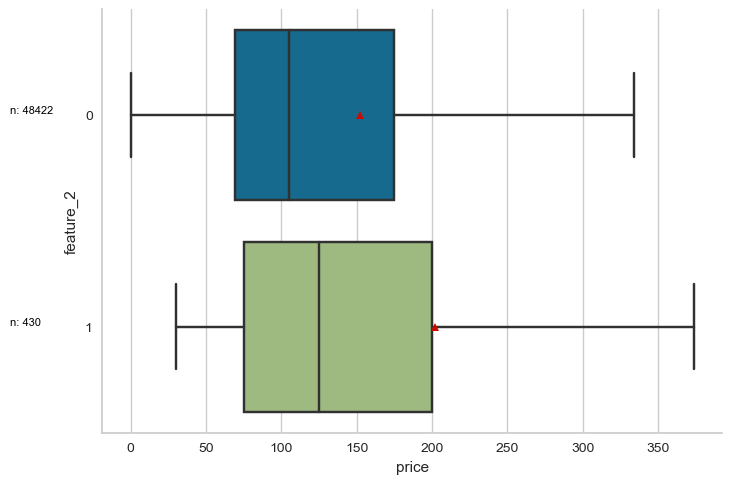

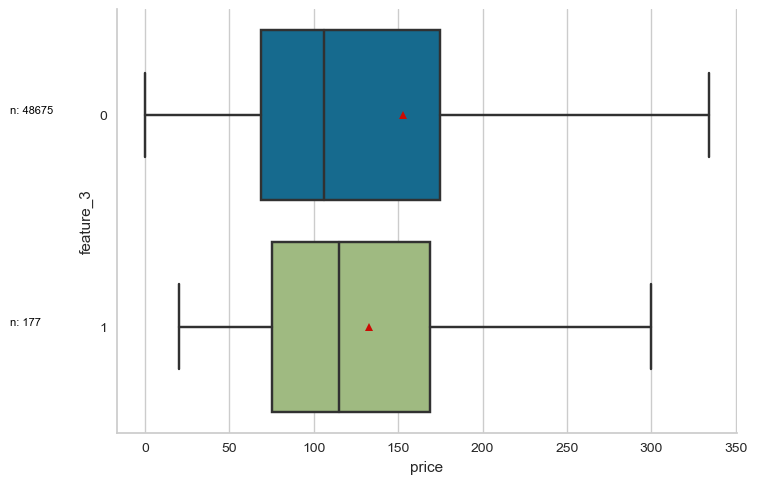

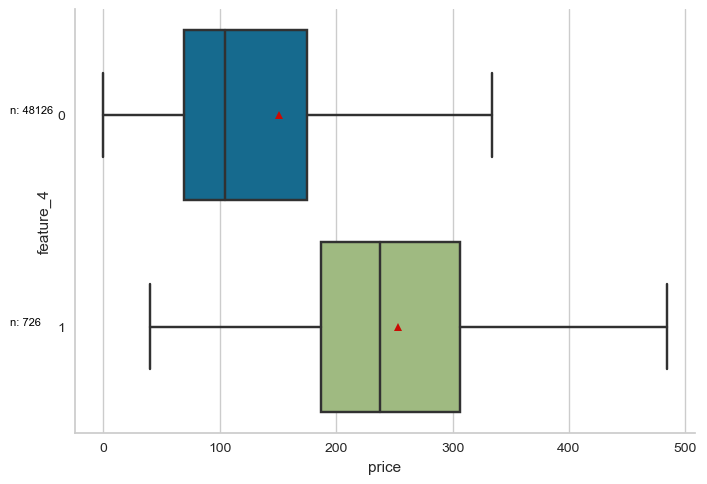

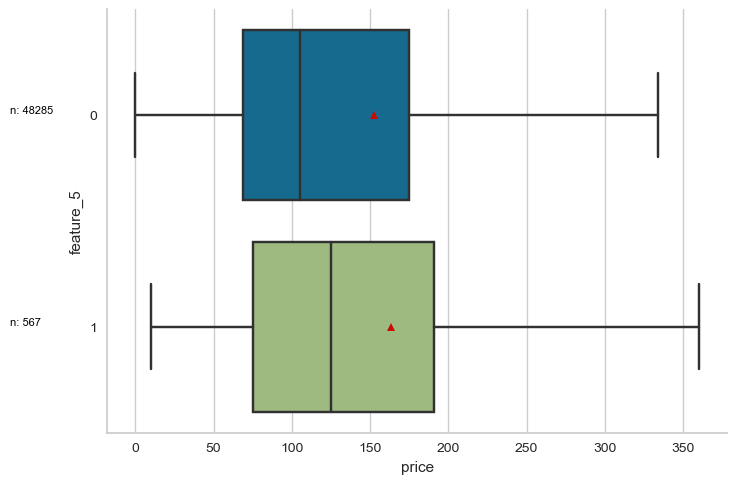

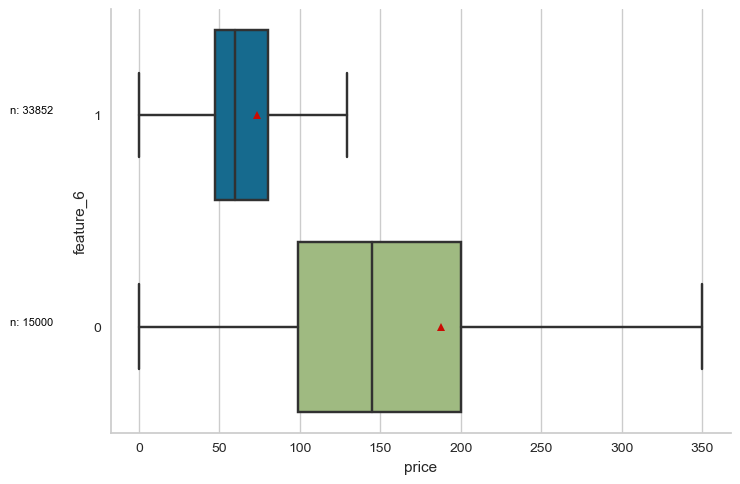

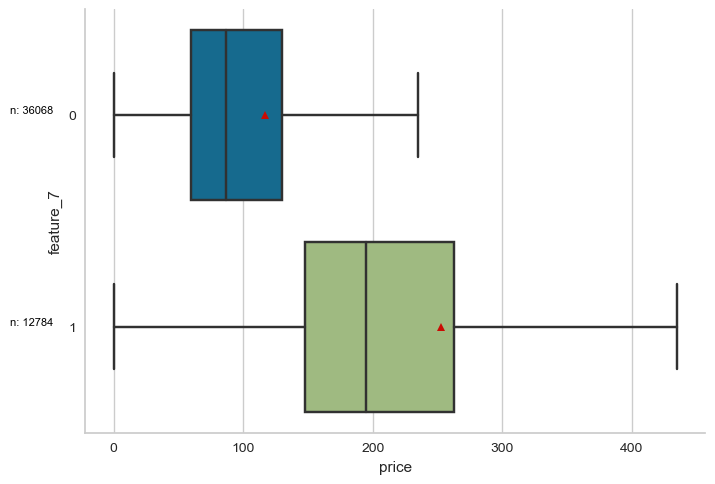

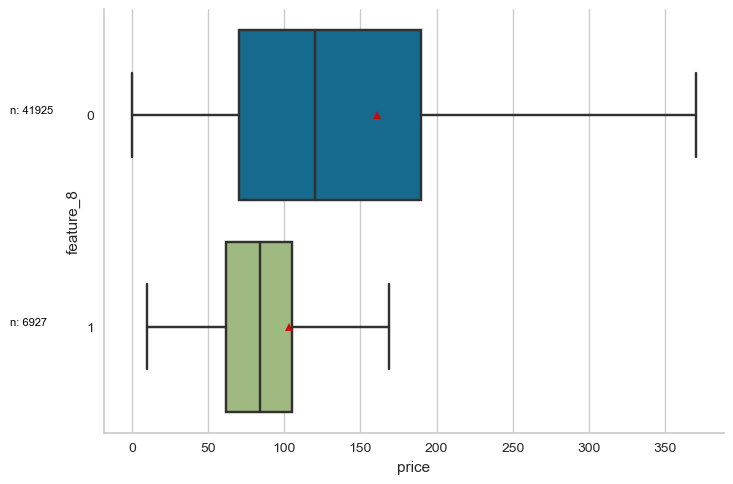

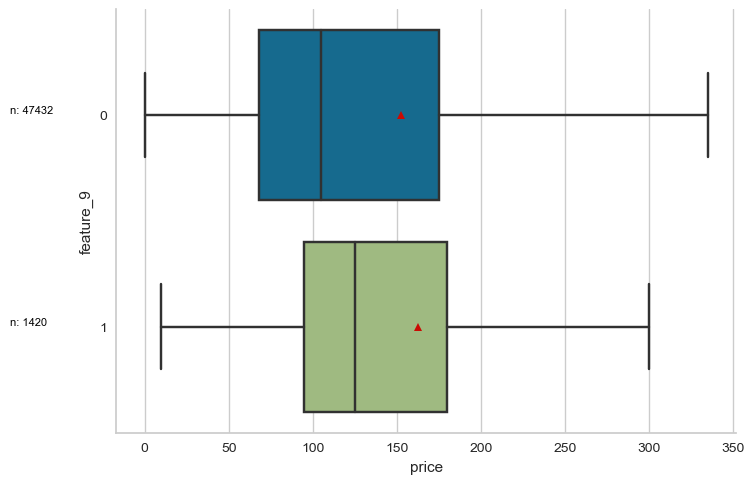

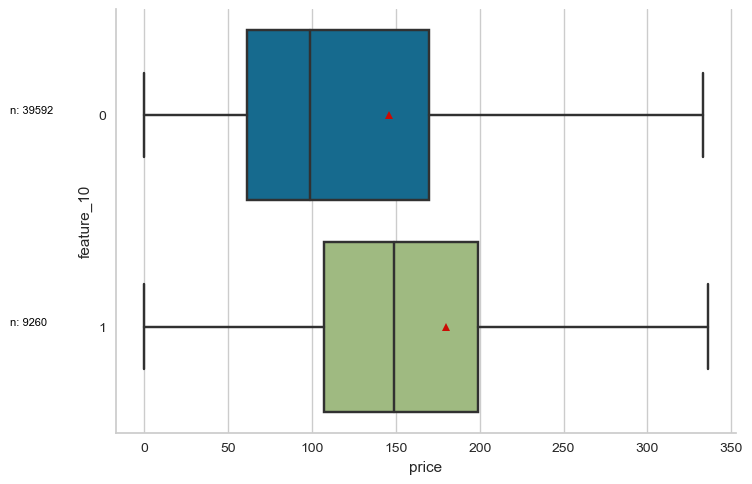

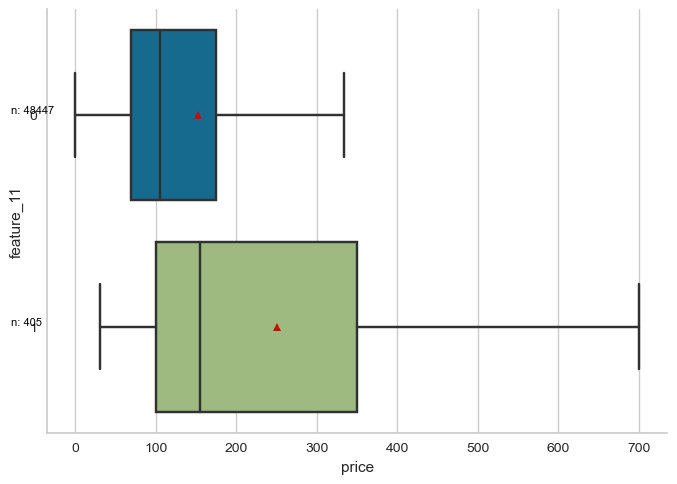

In [ ]:
for name in [col for col in df.columns if 'feature_' in col]:

    dfa = df.copy()
    dfa[name] = dfa[name].astype(str)

    ax = sns.boxplot(x="price", y=name, data=dfa, showfliers = False, showmeans = True)
    medians = dfa.groupby([name])['price'].median().values
    medians = np.array([-80, -80])
    nobs = dfa[name].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_yticklabels()):
        ax.text(medians[tick],tick,nobs[tick],color='black', verticalalignment = "bottom", size=8, fontdict=None)
    sns.despine()
    plt.show();

### Prediction

In [16]:
mod_data = df.drop(['host_id','latitude','longitude','name'], axis = 1)

In [17]:
a = pd.DataFrame(mod_data.isna().mean().round(4) * 100, columns = ['Count'])
a[a.Count > 0]

Count
reviews_per_month  20.54

In [18]:
y = mod_data.price
X = mod_data.drop(['price'], axis = 1)
X.head()

host_name neighbourhood_group neighbourhood       room_type  \
0         john            Brooklyn    Kensington    Private_room   
1     jennifer           Manhattan       Midtown  Entire_homeapt   
2    elisabeth           Manhattan        Harlem    Private_room   
3  lisaroxanne            Brooklyn  Clinton_Hill  Entire_homeapt   
4        laura           Manhattan   East_Harlem  Entire_homeapt   

   minimum_nights  number_of_reviews  reviews_per_month  \
0               1                  9               0.21   
1               1                 45               0.38   
2               3                  0                NaN   
3               1                270               4.64   
4              10                  9               0.10   

   calculated_host_listings_count  availability_365  time_since  ...  \
0                               6               365         262  ...   
1                               2               355          48  ...   
2                               1               365          50  ...   
3                               1               194           3  ...   
4                               1                 0         231  ...   

   feature_2  feature_3  feature_4  feature_5  feature_6  feature_7  \
0          0          0          0          0          1          0   
1          0          0          0          0          0          1   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          1   

   feature_8  feature_9  feature_10  feature_11  
0          0          0           0           0  
1          0          0           0           0  
2          0          0           0           0  
3          0          0           1           0  
4          0          0           0           0  

[5 rows x 23 columns]

#### Test-Train split

In [19]:
skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

TRAIN: [  430  1100  1103 ... 48849 48850 48851] TEST: [    0     1     2 ... 45930 47022 48492]
TRAIN: [    0     1     2 ... 48849 48850 48851] TEST: [  430  1103  1353 ... 47350 48077 48519]
TRAIN: [    0     1     2 ... 48849 48850 48851] TEST: [ 1100  2518  3603 ... 46854 48038 48522]
TRAIN: [    0     1     2 ... 48849 48850 48851] TEST: [ 2990  3679  3753 ... 47187 48190 48520]
TRAIN: [    0     1     2 ... 48519 48520 48522] TEST: [ 2231  4118  4875 ... 48849 48850 48851]
(39082, 23) (9770, 23) (39082,) (9770,)


The least populated class in y has only 1 members, which is less than n_splits=5.


#### Infilling

In [20]:
check = X_train.groupby("neighbourhood_group")["reviews_per_month"].mean()
X_train["reviews_per_month"] = X_train.groupby("neighbourhood_group")["reviews_per_month"].transform(lambda x: x.fillna(x.mean()))
X_test["reviews_per_month"] = X_train.groupby("neighbourhood_group")["reviews_per_month"].transform(lambda x: x.fillna(x.mean()))
check


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


neighbourhood_group
Bronx            1.605320
Brooklyn         1.134716
Manhattan        1.083233
Queens           1.699779
Staten_Island    1.739600
Name: reviews_per_month, dtype: float64

In [21]:
a = pd.DataFrame(X_train.isna().mean().round(4) * 100, columns = ['Count'])
a[a.Count > 0]

Empty DataFrame
Columns: [Count]
Index: []

In [22]:
a = pd.DataFrame(X_train.isna().mean().round(4) * 100, columns = ['Count'])
a[a.Count > 0]

Empty DataFrame
Columns: [Count]
Index: []

#### New features (not needed to rerun)

In [ ]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_miss' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))
num_cols = num_cols + ['price']

X_train_b = pd.concat([X_train,y_train], axis = 1)

for m_val in num_cols:
    X_train_b[m_val + '_bin'], bin_edges  = pd.qcut(X_train_b[m_val],
                                                   q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                                                   retbins = True,
                                                   duplicates = 'drop')
    print(m_val, bin_edges,range(len(bin_edges)-1))

    X_train_b[m_val + '_bin']  = pd.cut(X_train_b[m_val],
                                       bins = bin_edges,
                                       labels = range(len(bin_edges)-1),
                                       duplicates = 'drop',
                                       include_lowest=True)
    X_train_b[m_val + '_bin']  = X_train_b[m_val + '_bin'].astype(str)
    X_train_b.loc[X_train_b[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'

time_since [   0.    8.   16.   31.   50.  103.  266.  552.  990. 3024.] range(0, 9)
calculated_host_listings_count [  1.   2.   5. 327.] range(0, 3)
availability_365 [  0.  25.  83. 170. 261. 332. 365.] range(0, 6)
number_of_reviews [  0.   1.   2.   4.   7.  13.  24.  43.  84. 629.] range(0, 9)
company [0. 1.] range(0, 1)
minimum_nights [  1.   2.   3.   4.   6.  25. 364.] range(0, 6)
reviews_per_month [1.00000000e-02 7.00000000e-02 1.50000000e-01 2.70000000e-01
 4.80000000e-01 8.60000000e-01 1.08323305e+00 1.15000000e+00
 1.83000000e+00 3.02000000e+00 1.97500000e+01] range(0, 10)
price [    0.    49.    60.    75.    90.   106.   130.   155.   200.   269.
 10000.] range(0, 10)


In [ ]:
cat_cols = X_train.select_dtypes(include=np.object).columns.tolist()
print(cat_cols)

['host_name', 'neighbourhood_group', 'neighbourhood', 'room_type']


`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
bin_m_data = [col for col in X_train_b.columns if '_bin' in col and '_miss_' not in col]
print(bin_m_data)
X_train_b[bin_m_data + cat_cols].head()

['calculated_host_listings_count_bin', 'time_since_bin', 'reviews_per_month_bin', 'company_bin', 'availability_365_bin', 'number_of_reviews_bin', 'minimum_nights_bin', 'price_bin']


calculated_host_listings_count_bin time_since_bin reviews_per_month_bin  \
0                                  2              5                     2   
1                                  0              3                     3   
2                                  0              3                     5   
3                                  0              0                     9   
4                                  0              5                     1   

  company_bin availability_365_bin number_of_reviews_bin minimum_nights_bin  \
0           0                    5                     4                  0   
1           0                    5                     7                  0   
2           0                    5                     0                  1   
3           0                    3                     8                  0   
4           0                    0                     4                  4   

  price_bin    host_name neighbourhood_group neighbourhood       room_type  
0         6         john            Brooklyn    Kensington    Private_room  
1         8     jennifer           Manhattan       Midtown  Entire_homeapt  
2         6    elisabeth           Manhattan        Harlem    Private_room  
3         3  lisaroxanne            Brooklyn  Clinton_Hill  Entire_homeapt  
4         3        laura           Manhattan   East_Harlem  Entire_homeapt

In [ ]:
pd.crosstab(X_train_b.price_bin, columns = 'Count')
X_train_b.loc[(X_train_b.price_bin.isin(['0','1'])),'price_class'] = 0
X_train_b.loc[(X_train_b.price_bin.isin(['8','9'])),'price_class'] = 1
pd.crosstab(X_train_b.price_class, columns = 'Count')

col_0        Count
price_class       
0.0           8047
1.0           6699

In [ ]:
bin_m_data.remove('price_bin')
#cat_cols.remove('Country')
a = bin_m_data + cat_cols
a.sort()
print(a)

['availability_365_bin', 'calculated_host_listings_count_bin', 'company_bin', 'host_name', 'minimum_nights_bin', 'neighbourhood', 'neighbourhood_group', 'number_of_reviews_bin', 'reviews_per_month_bin', 'reviews_per_month_bin', 'room_type', 'time_since_bin']


In [ ]:
print(X_train_b.shape)
X_train_b = X_train_b[~X_train_b.price_class.isna()]
print(X_train_b.shape)
y = X_train_b.price_class
X = X_train_b[bin_m_data + cat_cols]

(39082, 26)
(14746, 26)


In [ ]:
ohe = OneHotEncoder()

ohe.fit(X)
colnames = ohe.get_feature_names_out(list(X.columns))

bin_data_train = ohe_dset(X,list(X.columns))
print(bin_data_train.shape)

(14746, 5121)
(14746, 5121)


In [ ]:
clf = DecisionTreeClassifier(max_depth=5, random_state=1234)
model = clf.fit(bin_data_train, y)

text_representation = tree.export_text(clf, feature_names=list(bin_data_train.columns))

In [ ]:
rule_lst = []
flattened_lst = []

minutes = 2
t_end = time.time() + 60 * minutes

while time.time() < t_end:
    rules, proba = get_rules(clf, list(bin_data_train.columns), [0,1], 80, 40)
    rule_lst.append(list(set(rules)))
    flattened_lst = [val for sublist in rule_lst for val in sublist]
    flattened_lst = list(set(flattened_lst))

In [ ]:
flattened_lst

['if (room_type_Entire_homeapt <= 0.5) and (neighbourhood_Midtown <= 0.5) and (neighbourhood_group_Manhattan <= 0.5) and (host_name_the_box_house_hotel <= 0.5) and (host_name_ana_y_victor <= 0.5) then class: 0 (proba: 97.38%) | based on 6,448 samples',
 'if (room_type_Entire_homeapt > 0.5) and (neighbourhood_group_Manhattan > 0.5) and (neighbourhood_Washington_Heights <= 0.5) and (neighbourhood_Inwood <= 0.5) and (host_name_carolann <= 0.5) then class: 1 (proba: 99.06%) | based on 4,277 samples',
 'if (room_type_Entire_homeapt <= 0.5) and (neighbourhood_Midtown <= 0.5) and (neighbourhood_group_Manhattan > 0.5) and (neighbourhood_Hells_Kitchen <= 0.5) and (availability_365_bin_5 <= 0.5) then class: 0 (proba: 88.24%) | based on 1,471 samples',
 'if (room_type_Entire_homeapt > 0.5) and (neighbourhood_group_Manhattan <= 0.5) and (neighbourhood_group_Brooklyn <= 0.5) and (availability_365_bin_0 <= 0.5) and (availability_365_bin_1 <= 0.5) then class: 1 (proba: 82.03%) | based on 217 samples'

#### Binning data

In [23]:
m_val_lst = ['reviews_per_month']

for m_val in m_val_lst:
    check = X_train[~X_train[m_val].isna()]
    check[m_val + '_bin'], bin_edges  = pd.qcut(check[m_val],
                                                   q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                                                   retbins = True,
                                                   duplicates = 'drop')
    print(m_val, bin_edges,range(len(bin_edges)-1))

    X_train[m_val + '_bin']  = pd.cut(X_train[m_val],
                                       bins = bin_edges,
                                       labels = range(len(bin_edges)-1),
                                       duplicates = 'drop',
                                       include_lowest=True)
    X_train[m_val + '_bin']  = X_train[m_val + '_bin'].astype(str)
    X_train.loc[X_train[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'

    ### Test data ###
    X_test[m_val + '_bin'] = pd.cut(X_test[m_val],
                                    bins = bin_edges,
                                    labels = range(len(bin_edges)-1),
                                    include_lowest=True)

    X_test[m_val + '_bin'] = X_test[m_val + '_bin'].astype('str')
    X_test.loc[X_test[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'

X_train = X_train.drop(m_val_lst, axis = 1)
X_test = X_test.drop(m_val_lst, axis = 1)

reviews_per_month [1.00000000e-02 7.00000000e-02 1.50000000e-01 2.70000000e-01
 4.80000000e-01 8.60000000e-01 1.08323305e+00 1.15000000e+00
 1.83000000e+00 3.02000000e+00 1.97500000e+01] range(0, 10)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [ ]:
#pd.crosstab(X_train.reviews_per_month_bin, columns = 'Count')

#### Numeric data

In [ ]:
#pd.crosstab(X_train.gender,columns = 'Count')

In [ ]:
#pd.crosstab(X_test.gender,columns = 'Count')

In [24]:
#########################################
### Check for single non varying data ###
#########################################

lst = []
for name in list(X_train.columns):
    if (X_train[name].nunique() == 1):
        lst.append(name)

print(lst)

[]


In [25]:
try:
    X_train = X_train.drop(lst, axis=1)
    X_test = X_test.drop(lst, axis=1)
except:
    X_train = X_train
    X_test = X_test

In [26]:
#########################
### Multicollinearity ###
#########################

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

vif = calculate_vif(X_train[num_cols])

a = vif[(vif.VIF > 10)]
to_drop_vif = list(a.Features)
print(to_drop_vif)



['company', 'feature_1', 'feature_4']


In [27]:
try:
    X_train = X_train.drop(to_drop_vif, axis=1)
    X_test = X_test.drop(to_drop_vif, axis=1)
except:
    X_train = X_train
    X_test = X_test

In [28]:
num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_miss' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))

#sns.pairplot(X_train[num_cols])
#plt.show();

In [29]:
num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_miss' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))
print(num_cols)

['availability_365', 'minimum_nights', 'number_of_reviews', 'time_since', 'calculated_host_listings_count']


`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[]


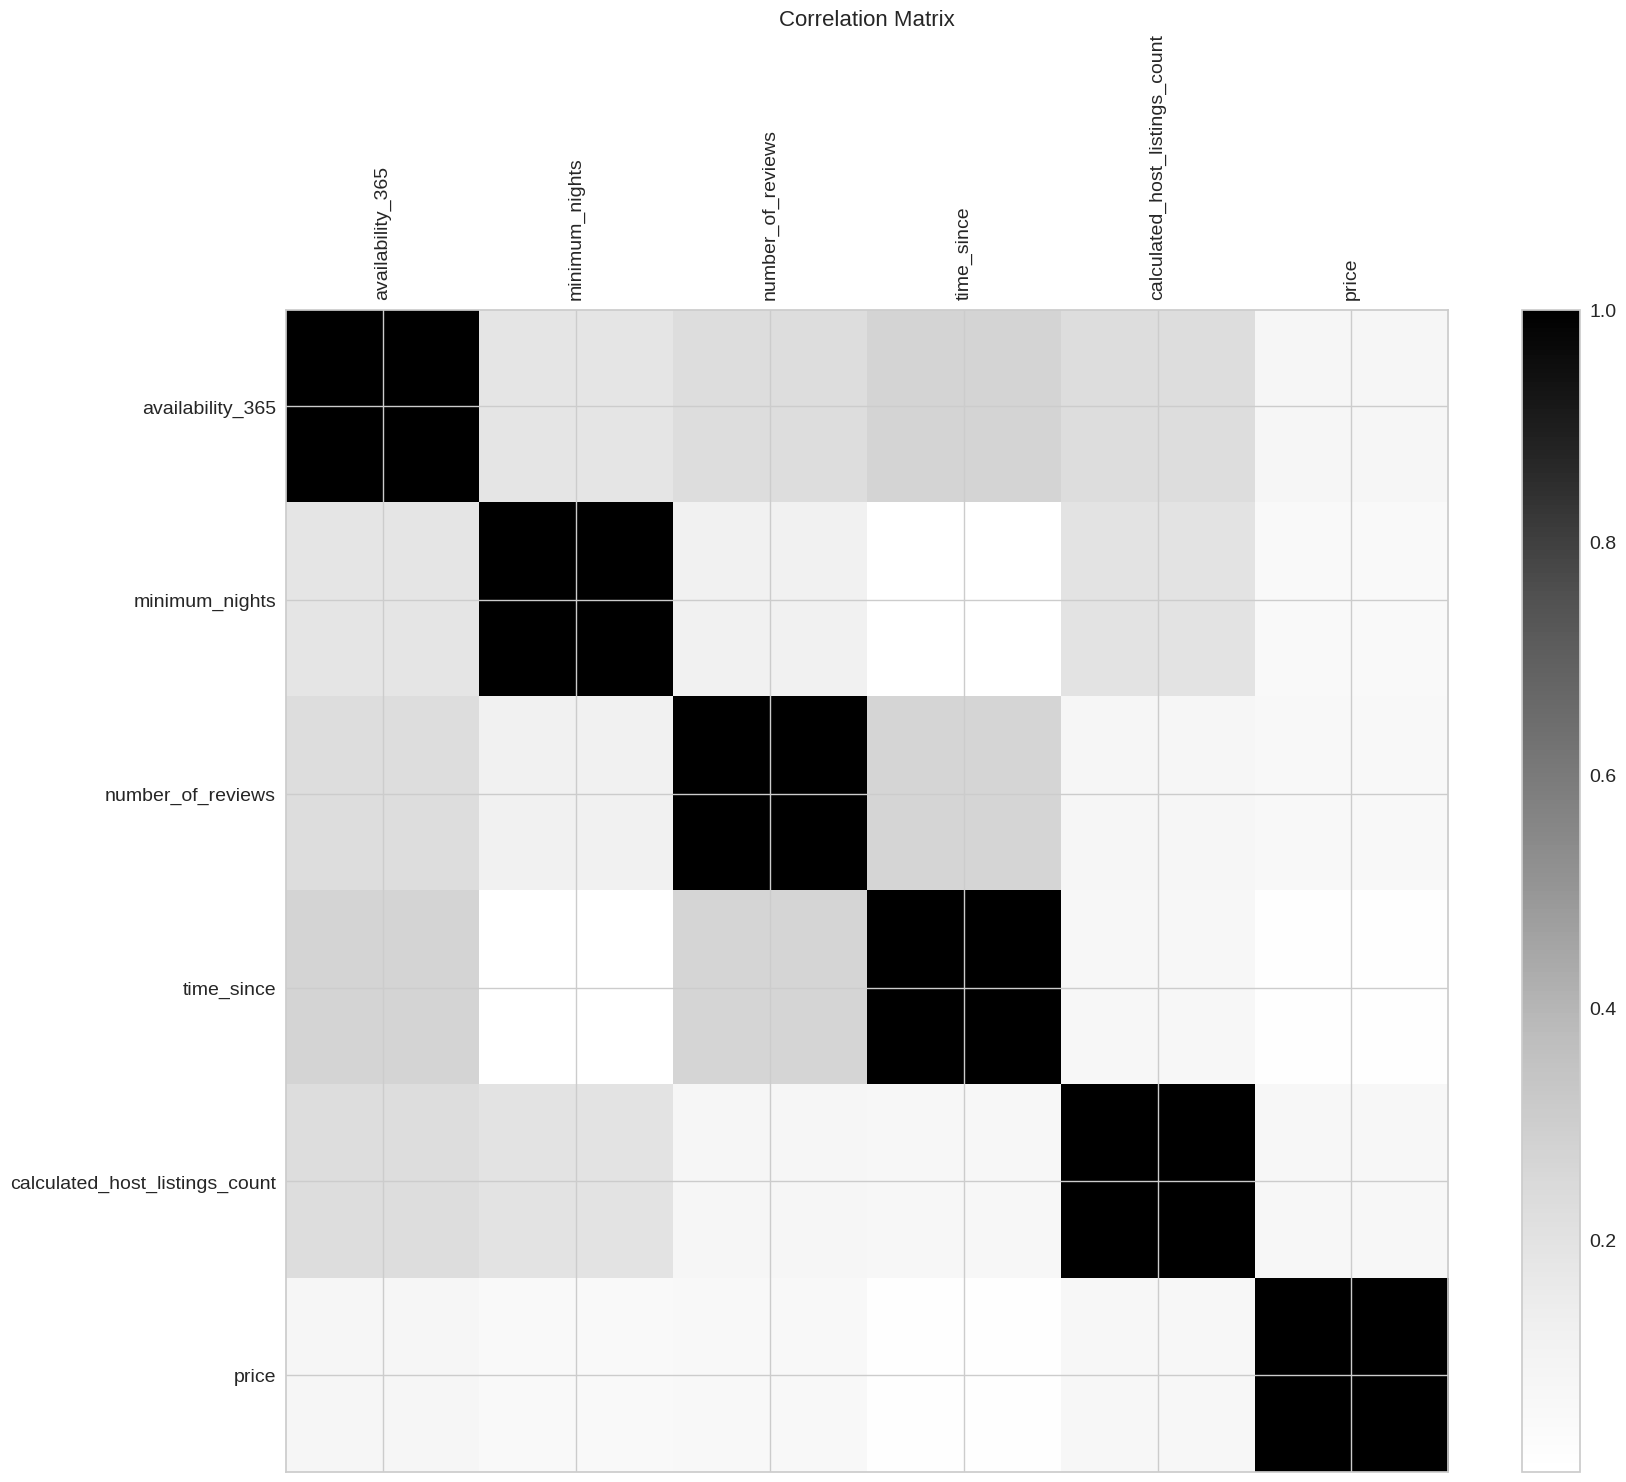

In [30]:
###################
### Correlation ###
###################

corre_data = pd.concat([X_train[num_cols],
                        pd.DataFrame(y_train)],
                       axis = 1)

cor_matrix = corre_data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

f = plt.figure(figsize=(19, 15))
plt.matshow(cor_matrix, fignum=f.number)
plt.xticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show();

In [31]:
#####################
### MinMax scaler ###
#####################

num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_miss' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))

print(X_train[num_cols].shape)

transformer_train = MinMaxScaler().fit(X_train[num_cols])
num_data_train = pd.DataFrame(transformer_train.transform(X_train[num_cols]))
num_data_train.columns = num_cols
print(num_data_train.shape)

num_data_test = minmax_dset(X_test,num_cols) ### Test ###

(39082, 5)
(39082, 5)
(9770, 5)


#### Categorical data

In [32]:
cat_cols = list(X_train.select_dtypes(include=['object']))
print(cat_cols)

['host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'reviews_per_month_bin']


In [33]:
###################################
### High cardinality adjustment ###
###################################

card_vars = []
cat_data = X_train[cat_cols]
for i in range(cat_data.shape[1]):
    X_train.loc[X_train[cat_data.columns[i]].isnull(),cat_data.columns[i]] = 'Missing'
    X_test.loc[X_test[cat_data.columns[i]].isnull(),cat_data.columns[i]] = 'Missing'

    if (cat_data.iloc[:,i].nunique() > 60):
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))

        a = pd.crosstab(cat_data[cat_data.columns[i]],columns='Count')
        a = pd.DataFrame(a).sort_values('Count',ascending=False).reset_index()
        val_list = list(a.iloc[:20,0])
        X_train.loc[~X_train[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'
        X_test.loc[~X_test[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'

    if (len(list(set(cat_data.iloc[:,i]))) > 100):
        card_vars.append(cat_data.columns[i])

print(card_vars)

host_name 9705
neighbourhood 221
['host_name', 'neighbourhood']


In [34]:
########################
### One hot encoding ###
########################

ohe = OneHotEncoder()
print(X_train.shape)
# (1808, 10)

### Train ###

ohe.fit(X_train[cat_cols])
colnames = ohe.get_feature_names_out(cat_cols)

cat_data_train = ohe_dset(X_train,cat_cols)  ### Train ###
cat_data_test = ohe_dset(X_test,cat_cols)    ### Test ###

(39082, 20)
(39082, 60)
(9770, 51)


#### Bin data

In [35]:
bin_data_cols = [col for col in X_train.columns if '_miss' in col] + [col for col in X_train.columns if 'feature_' in col]
print(bin_data_cols)

['time_since_miss', 'feature_2', 'feature_3', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11']


In [36]:
bin_data_train = X_train[bin_data_cols]
bin_data_test = X_test[bin_data_cols]

print(bin_data_train.shape)

(39082, 10)


In [37]:
print(list(cat_data_train.columns))

print(list(num_data_train.columns))

print(list(bin_data_train.columns))

['host_name_Other', 'host_name_alex', 'host_name_andrew', 'host_name_anna', 'host_name_blueground', 'host_name_chris', 'host_name_daniel', 'host_name_david', 'host_name_emily', 'host_name_james', 'host_name_jennifer', 'host_name_jessica', 'host_name_john', 'host_name_kara', 'host_name_laura', 'host_name_maria', 'host_name_melissa', 'host_name_michael', 'host_name_mike', 'host_name_sarah', 'host_name_sonder_(nyc)', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten_Island', 'neighbourhood_Astoria', 'neighbourhood_Bedford_Stuyvesant', 'neighbourhood_Bushwick', 'neighbourhood_Chelsea', 'neighbourhood_Clinton_Hill', 'neighbourhood_Crown_Heights', 'neighbourhood_East_Harlem', 'neighbourhood_East_Village', 'neighbourhood_Financial_District', 'neighbourhood_Flatbush', 'neighbourhood_Greenpoint', 'neighbourhood_Harlem', 'neighbourhood_Hells_Kitchen', 'neighbourhood_Lower_East_Side', 'neighbourh

In [38]:
###########################
### Bring data together ###
###########################

print(cat_data_train.shape, num_data_train.shape, bin_data_train.shape)
cat_data_train = cat_data_train.reset_index()
num_data_train = num_data_train.reset_index()
bin_data_train = bin_data_train.reset_index()

X_train = pd.concat([cat_data_train,num_data_train],axis = 1)
print(X_train.shape)
X_train = pd.concat([X_train,bin_data_train],axis = 1)
print(X_train.shape)

print(cat_data_test.shape, num_data_test.shape, bin_data_test.shape)
cat_data_test = cat_data_test.reset_index()
num_data_test = num_data_test.reset_index()
bin_data_test = bin_data_test.reset_index()
X_test = pd.concat([cat_data_test,num_data_test],axis = 1)
X_test = pd.concat([X_test,bin_data_test],axis = 1)

print(X_train.shape, X_test.shape)

# (39116, 60) (9779, 60)

(39082, 60) (39082, 5) (39082, 10)
(39082, 67)
(39082, 78)
(9770, 51) (9770, 5) (9770, 10)
(39082, 78) (9770, 69)


In [39]:
####################################################
### Check that train/test sets have same columns ###
####################################################

mod_cols = (list(set(list(X_train.columns)) - set(['index'])))
X_train = X_train[mod_cols]
miss_lst = list(set(list(X_train.columns)) - set(list(X_test.columns)))

for name in miss_lst:
    X_test[name] = 0
X_test = X_test[list(X_train.columns)]

drop_test_lst = list(set(list(X_test.columns)) - set(list(X_train.columns)))
X_test = X_test.drop(drop_test_lst, axis = 1)

print(X_train.shape, X_test.shape)
# (39082, 75) (9770, 75)

(39082, 75) (9770, 75)


#### Mutual information check

In [ ]:
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns

In [ ]:
mutual_info = mutual_info.sort_values(ascending=False)
mutual_info[:20]

room_type_Entire_homeapt          0.286558
room_type_Private_room            0.247318
feature_6                         0.224936
feature_7                         0.174966
calculated_host_listings_count    0.158824
neighbourhood_group_Manhattan     0.071797
minimum_nights                    0.057188
feature_10                        0.056946
availability_365                  0.040902
feature_8                         0.032278
time_since                        0.028476
number_of_reviews                 0.027796
neighbourhood_group_Brooklyn      0.025785
room_type_Shared_room             0.022563
neighbourhood_Midtown             0.022440
neighbourhood_group_Queens        0.020434
time_since_miss                   0.019161
reviews_per_month_bin_5           0.017990
neighbourhood_Bushwick            0.015821
neighbourhood_West_Village        0.015589
dtype: float64

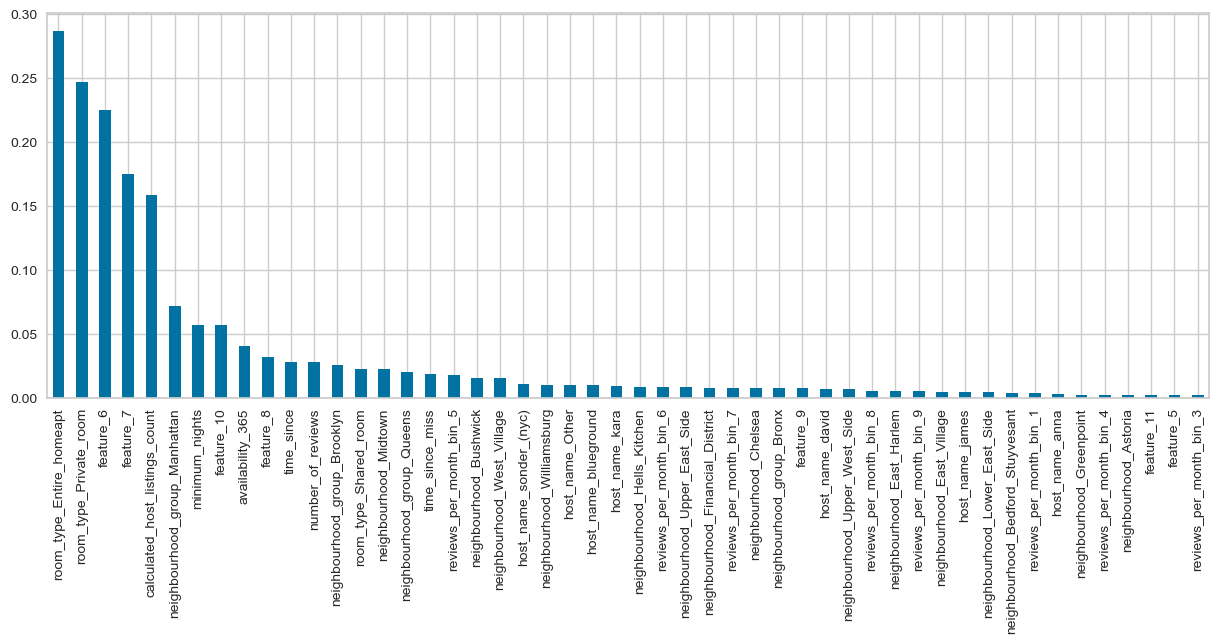

In [ ]:
mutual_info[:50].sort_values(ascending=False).plot.bar(figsize=(15,5))
plt.show()

### Clustering

In [ ]:
clust_data = df[~df.isnull().any(axis=1)]
print(clust_data.shape)
print(list(clust_data.columns))

(38812, 17)
['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'time_since', 'time_since_miss', 'gender']


In [ ]:
clust_data = clust_data.drop(['name','host_id'], axis = 1)

cat_cols = list(clust_data.select_dtypes(include=['object']))
print('Object data: ', cat_cols)

print('Datetime data: ',list(clust_data.select_dtypes(include=['datetime']).columns))

print('Timedelta data: ',list(clust_data.select_dtypes(include=['timedelta']).columns))

num_cols = list(clust_data.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
print('Numeric data: ', num_cols)

Object data:  ['host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'gender']
Datetime data:  []
Timedelta data:  []
Numeric data:  ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'time_since', 'time_since_miss']


In [ ]:
num_data = clust_data[list(clust_data.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)]
print(num_data.shape)
# (74869, 21)
num_data.describe()

(38812, 10)


latitude     longitude         price  minimum_nights  \
count  38812.000000  38812.000000  38812.000000    38812.000000   
mean      40.728135    -73.951131    142.293028        5.574565   
std        0.054997      0.046703    196.962796       11.512464   
min       40.506410    -74.244420      0.000000        1.000000   
25%       40.688640    -73.982450     69.000000        1.000000   
50%       40.721710    -73.954790    101.000000        2.000000   
75%       40.763000    -73.935010    170.000000        4.000000   
max       40.913060    -73.712990  10000.000000      364.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count       38812.000000       38812.000000                    38812.000000   
mean           29.313666           1.374078                        5.166984   
std            48.201647           1.680805                       26.305844   
min             1.000000           0.010000                        1.000000   
25%             3.000000           0.190000                        1.000000   
50%             9.000000           0.720000                        1.000000   
75%            33.000000           2.020000                        2.000000   
max           629.000000          58.500000                      327.000000   

       availability_365    time_since  time_since_miss  
count      38812.000000  38812.000000          38812.0  
mean         114.809698    276.513784              1.0  
std          129.493635    413.499230              0.0  
min            0.000000      0.000000              1.0  
25%            0.000000     15.000000              1.0  
50%           55.000000     50.000000              1.0  
75%          229.000000    363.000000              1.0  
max          365.000000   3024.000000              1.0

In [ ]:
#####################
### Normalisation ###
#####################

numerical_features = pd.DataFrame(MinMaxScaler(feature_range=(0, 1)).fit_transform(
    num_data[num_cols]), index=num_data.index, columns=num_cols)

print(
    f'Data min:max {numerical_features.min().min(),numerical_features.max().max()}')

Data min:max (0.0, 1.0)


In [ ]:
###################################
### High cardinality adjustment ###
###################################

card_vars = []
cat_data = clust_data[cat_cols]
cat_data_vals = cat_data.copy()
for i in range(cat_data.shape[1]):

    if (len(list(set(cat_data.iloc[:,i]))) > 60):
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))

        a = pd.crosstab(cat_data[cat_data.columns[i]],columns='Count')
        a = pd.DataFrame(a).sort_values('Count',ascending=False).reset_index()
        val_list = list(a.iloc[:20,0])
        cat_data_vals.loc[~cat_data_vals[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'

    elif cat_data.iloc[:,i].nunique() > 100:
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))
        card_vars.append(cat_data.columns[i])

print(card_vars)

host_name 9851
neighbourhood 218
[]


In [ ]:
ohe = OneHotEncoder()

transformed_dset = ohe.fit_transform(cat_data_vals[cat_cols])
cat_data = pd.DataFrame(transformed_dset.toarray())
cat_data.columns = ohe.get_feature_names_out(input_features=cat_data_vals[cat_cols].columns)

In [ ]:
cat_data = cat_data.drop(['gender_Person'], axis = 1)
print(cat_data.shape)
print(list(cat_data.columns))
print(
    f'Data min:max {cat_data.min().min(),cat_data.max().max()}')

(38812, 51)
['host_name_Other', 'host_name_alex', 'host_name_andrew', 'host_name_anna', 'host_name_chris', 'host_name_daniel', 'host_name_david', 'host_name_emily', 'host_name_james', 'host_name_jason', 'host_name_jennifer', 'host_name_jessica', 'host_name_john', 'host_name_laura', 'host_name_maria', 'host_name_melissa', 'host_name_michael', 'host_name_mike', 'host_name_rachel', 'host_name_sarah', 'host_name_sonder_(nyc)', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten_Island', 'neighbourhood_Astoria', 'neighbourhood_Bedford_Stuyvesant', 'neighbourhood_Bushwick', 'neighbourhood_Chelsea', 'neighbourhood_Clinton_Hill', 'neighbourhood_Crown_Heights', 'neighbourhood_East_Harlem', 'neighbourhood_East_Village', 'neighbourhood_Financial_District', 'neighbourhood_Flatbush', 'neighbourhood_Greenpoint', 'neighbourhood_Harlem', 'neighbourhood_Hells_Kitchen', 'neighbourhood_Lower_East_Side', 'n

In [ ]:
numerical_features = numerical_features.reset_index(drop=True)
cat_data = cat_data.reset_index(drop=True)
print(list(numerical_features.columns))
print(list(cat_data.columns))
all_data = pd.concat([numerical_features,cat_data], axis = 1)
print(all_data.shape)

['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'time_since', 'time_since_miss']
['host_name_Other', 'host_name_alex', 'host_name_andrew', 'host_name_anna', 'host_name_chris', 'host_name_daniel', 'host_name_david', 'host_name_emily', 'host_name_james', 'host_name_jason', 'host_name_jennifer', 'host_name_jessica', 'host_name_john', 'host_name_laura', 'host_name_maria', 'host_name_melissa', 'host_name_michael', 'host_name_mike', 'host_name_rachel', 'host_name_sarah', 'host_name_sonder_(nyc)', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten_Island', 'neighbourhood_Astoria', 'neighbourhood_Bedford_Stuyvesant', 'neighbourhood_Bushwick', 'neighbourhood_Chelsea', 'neighbourhood_Clinton_Hill', 'neighbourhood_Crown_Heights', 'neighbourhood_East_Harlem', 'neighbourhood_East_Village', 'neighbour

100%|██████████| 19/19 [00:16<00:00,  1.14it/s]


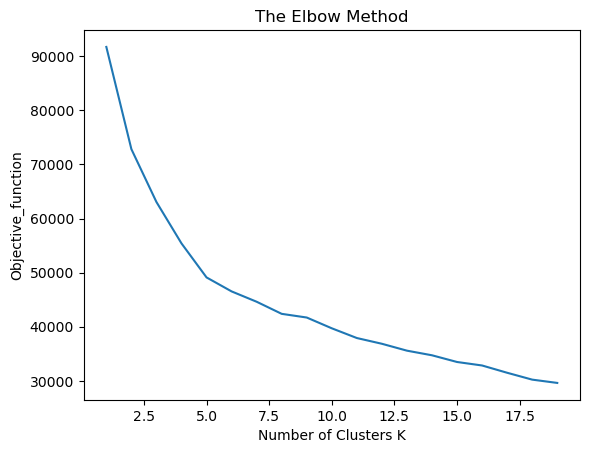

In [ ]:
objective_function = []
for i in tqdm(range(1, 20)):
    clustering = KMeans(n_clusters=i, init='k-means++')
    clustering.fit(all_data)
    objective_function.append(clustering.inertia_)

plt.plot(range(1, 20), objective_function)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters K')
plt.ylabel('Objective_function')
plt.show()

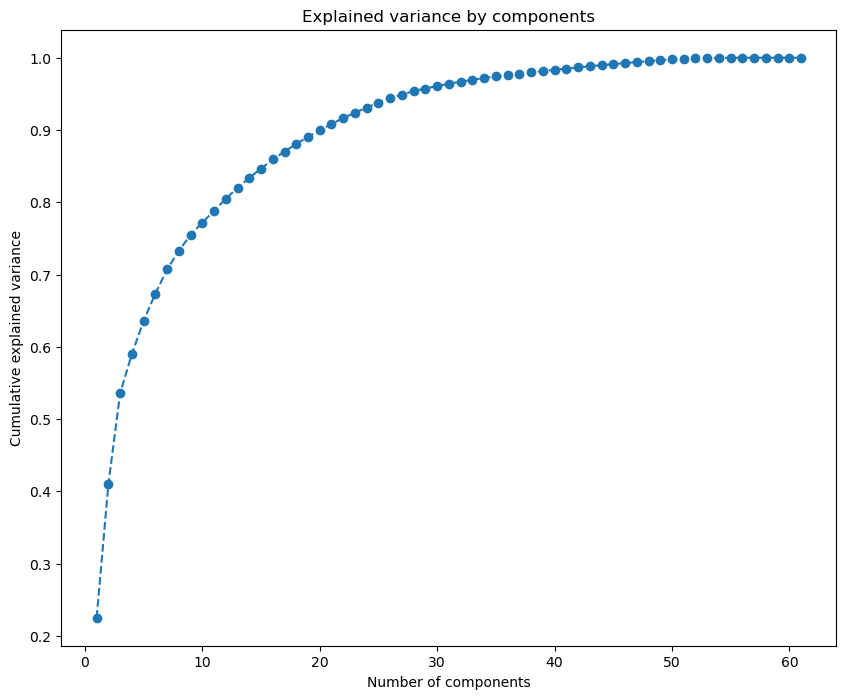

In [ ]:
###########
### PCA ###
###########

pca = PCA()
pca.fit(all_data)

plt.figure(figsize=(10,8))
plt.plot(range(1,len(pca.explained_variance_ratio_.cumsum())+1), pca.explained_variance_ratio_.cumsum(),
         marker='o',linestyle='--')
plt.title("Explained variance by components")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show();

In [ ]:
pca = PCA(n_components=12)
pca.fit(all_data)
scores_pca = pca.transform(all_data)

100%|██████████| 39/39 [00:31<00:00,  1.23it/s]


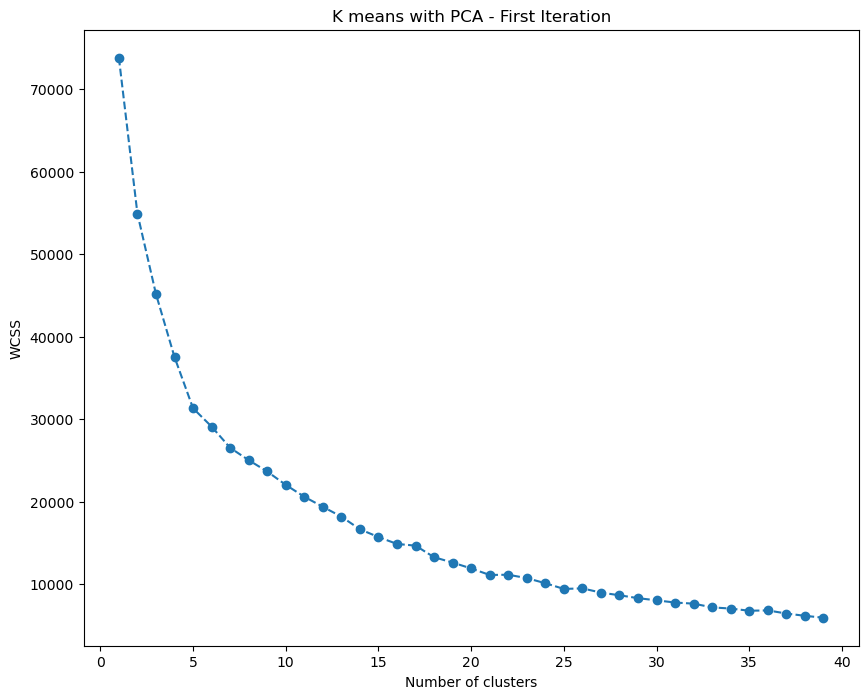

In [ ]:
wcss = []
for i in tqdm(range(1,40)):
    kmeans_pca = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(wcss)+1), wcss,
         marker='o', linestyle='--')
plt.title("K means with PCA - First Iteration")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show();

In [ ]:
tuned_clustering = KMeans(n_clusters=5, init='k-means++', random_state=0)
labels = tuned_clustering.fit_predict(all_data)

metrics.silhouette_score(
    all_data, tuned_clustering.labels_, metric='euclidean')

0.272336934032959

In [ ]:
for i in tqdm([5, 6, 7]):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(all_data)

100%|██████████| 3/3 [02:13<00:00, 44.43s/it]


In [ ]:
kmeans_pca = KMeans(n_clusters=5, init="k-means++", random_state=42)
kmeans_pca.fit(scores_pca)
df_segm_pca_means = pd.concat(
    [all_data.reset_index(drop=True), pd.DataFrame(scores_pca)],axis=1)

df_segm_pca_means.columns.values[-5:] = ['Component 1', 'Component 2','Component 3',
                                         'Component 4','Component 5']
df_segm_pca_means['Clusters'] = kmeans_pca.labels_
plt.show()

In [ ]:
pd.crosstab(kmeans_pca.labels_, columns='Count')

col_0  Count
row_0       
0       8442
1      10220
2       8164
3       5592
4       6394

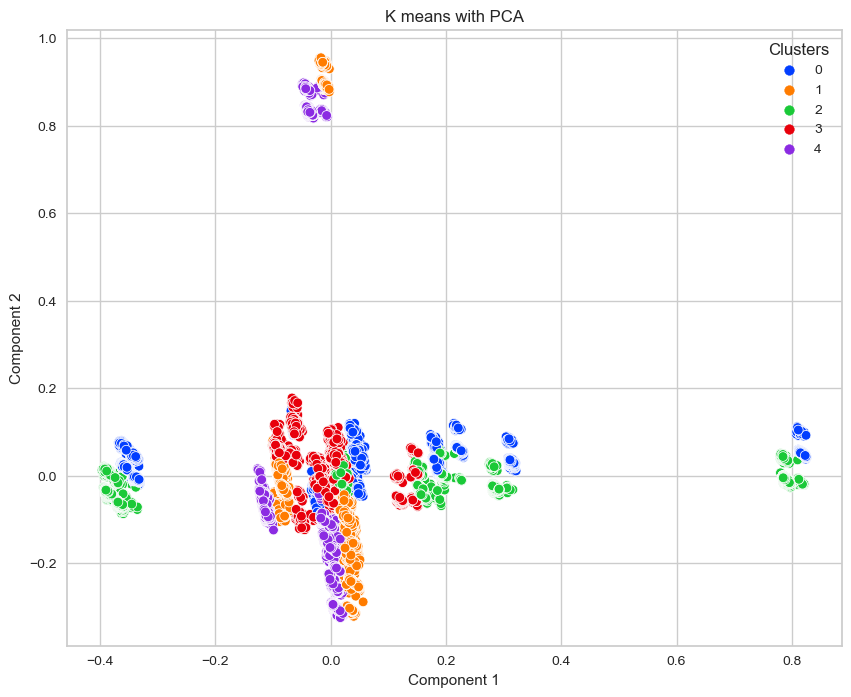

In [ ]:
x_axis = df_segm_pca_means['Component 1']
y_axis = df_segm_pca_means['Component 2']
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue=df_segm_pca_means['Clusters'], palette="bright")
plt.title("K means with PCA")
plt.show();

#### Calculate important columns

In [ ]:
a = list(all_data.columns)
try:
    a.remove('index')
except:
    a = list(all_data.columns)

clust_check = df_segm_pca_means.groupby(['Clusters']).mean()
clust_checks = clust_check[a]
print(clust_checks.shape)
clust_checks

(5, 61)


latitude  longitude     price  minimum_nights  number_of_reviews  \
Clusters                                                                     
0         0.434728   0.539117  0.016860        0.012730           0.050304   
1         0.621075   0.501705  0.022643        0.019166           0.036214   
2         0.440035   0.560195  0.007264        0.009488           0.040853   
3         0.589147   0.686287  0.009200        0.008413           0.052675   
4         0.665913   0.520807  0.010601        0.009580           0.051143   

          reviews_per_month  calculated_host_listings_count  availability_365  \
Clusters                                                                        
0                  0.022491                        0.002638          0.286074   
1                  0.019659                        0.034587          0.307735   
2                  0.021284                        0.004924          0.296811   
3                  0.032677                        0.006675          0.428666   
4                  0.024692                        0.006700          0.285870   

          time_since  time_since_miss  ...  neighbourhood_Other  \
Clusters                               ...                        
0           0.088687              0.0  ...             0.379176   
1           0.101700              0.0  ...             0.201761   
2           0.098914              0.0  ...             0.251592   
3           0.056441              0.0  ...             0.873212   
4           0.099740              0.0  ...             0.174226   

          neighbourhood_Upper_East_Side  neighbourhood_Upper_West_Side  \
Clusters                                                                 
0                              0.000000                       0.000000   
1                              0.101272                       0.093836   
2                              0.000000                       0.000000   
3                              0.000000                       0.000000   
4                              0.057710                       0.081795   

          neighbourhood_Washington_Heights  neighbourhood_West_Village  \
Clusters                                                                 
0                                 0.000000                    0.000000   
1                                 0.022798                    0.051370   
2                                 0.000000                    0.000000   
3                                 0.000000                    0.000000   
4                                 0.076165                    0.013294   

          neighbourhood_Williamsburg  room_type_Entire_homeapt  \
Clusters                                                         
0                           0.185856                  0.986496   
1                           0.000000                  0.973777   
2                           0.195002                  0.000000   
3                           0.000000                  0.362840   
4                           0.000000                  0.000000   

          room_type_Private_room  room_type_Shared_room  gender_Company  
Clusters                                                                 
0                       0.000000               0.013504        0.002132  
1                       0.000000               0.026223        0.025049  
2                       0.978442               0.021558        0.003185  
3                       0.601395               0.035765        0.001609  
4                       0.986237               0.013763        0.007194  

[5 rows x 61 columns]

In [ ]:
for name in a:

    mean_val = np.mean(clust_checks[name])
    clust_checks[str('Index_') + str(name)] = (clust_checks[name]/mean_val) * 100


In [ ]:
import_col = []
index_col = [col for col in clust_checks if col.startswith('Index')]
for name in index_col:
    if ((min(clust_checks[name]) < 60) | (max(clust_checks[name]) > 250)) & (min(clust_checks[name]) != 0):
        import_col.append(name)


In [ ]:
print(len(import_col), import_col)

10 ['Index_price', 'Index_calculated_host_listings_count', 'Index_host_name_andrew', 'Index_host_name_jennifer', 'Index_host_name_melissa', 'Index_host_name_mike', 'Index_host_name_rachel', 'Index_host_name_sarah', 'Index_neighbourhood_Other', 'Index_gender_Company']


In [ ]:
cluster_index = pd.concat(
    [clust_checks[import_col], df_segm_pca_means['Clusters']], axis=1)

In [ ]:
import_cols = [re.sub('^Index_', "", x) for x in cluster_index.columns]
import_cols.remove('Clusters')
print(import_cols)

['price', 'calculated_host_listings_count', 'host_name_andrew', 'host_name_jennifer', 'host_name_melissa', 'host_name_mike', 'host_name_rachel', 'host_name_sarah', 'neighbourhood_Other', 'gender_Company']


#### Second iteration

In [ ]:
all_data2 = all_data[import_cols]
print(all_data2.shape)
print(
    f'Data min:max {all_data2.min().min(),all_data2.max().max()}')

(38812, 10)
Data min:max (0.0, 1.0)


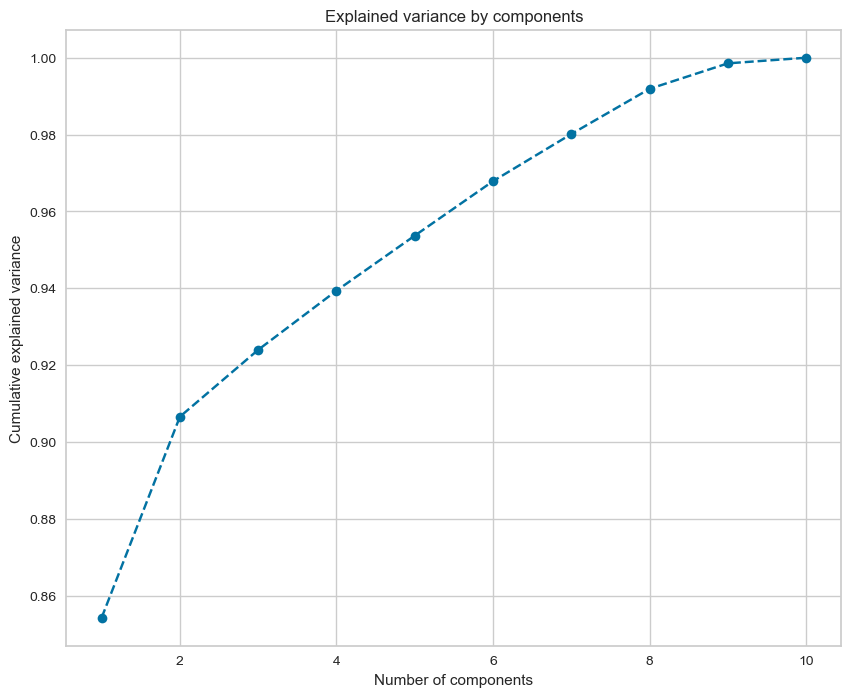

In [ ]:
###########
### PCA ###
###########

pca2 = PCA()
pca2.fit(all_data2)
plt.figure(figsize=(10,8))
plt.plot(range(1,len(pca2.explained_variance_ratio_.cumsum())+1), pca2.explained_variance_ratio_.cumsum(),
         marker='o',linestyle='--')
plt.title("Explained variance by components")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show();

In [ ]:
pca2 = PCA(n_components=3)
pca2.fit(all_data2)
scores_pca2 = pca2.transform(all_data2)

100%|██████████| 39/39 [00:19<00:00,  2.00it/s]


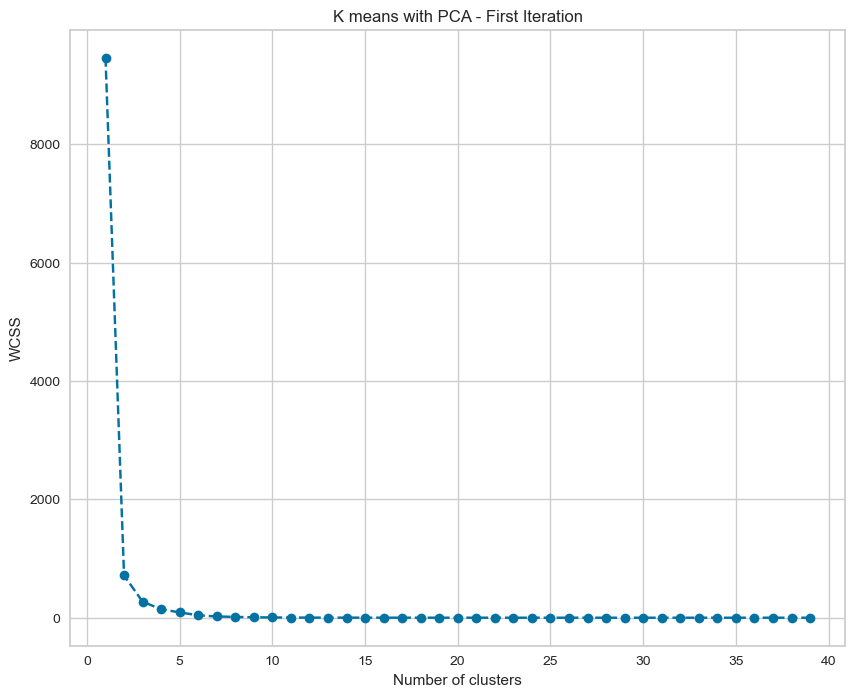

In [ ]:
wcss = []
for i in tqdm(range(1,40)):
    kmeans_pca = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
    kmeans_pca.fit(scores_pca2)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(wcss)+1), wcss,
         marker='o', linestyle='--')
plt.title("K means with PCA - First Iteration")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show();

In [ ]:
kmeans_pca2 = KMeans(n_clusters=4, init="k-means++", random_state=42)
kmeans_pca2.fit(scores_pca2)
df_segm_pca_means2 = pd.concat(
    [all_data2.reset_index(drop=True), pd.DataFrame(scores_pca2)], axis=1)
df_segm_pca_means2.columns.values[-3:] = ['Component 1', 'Component 2','Component 3']

df_segm_pca_means2['Clusters'] = kmeans_pca2.labels_

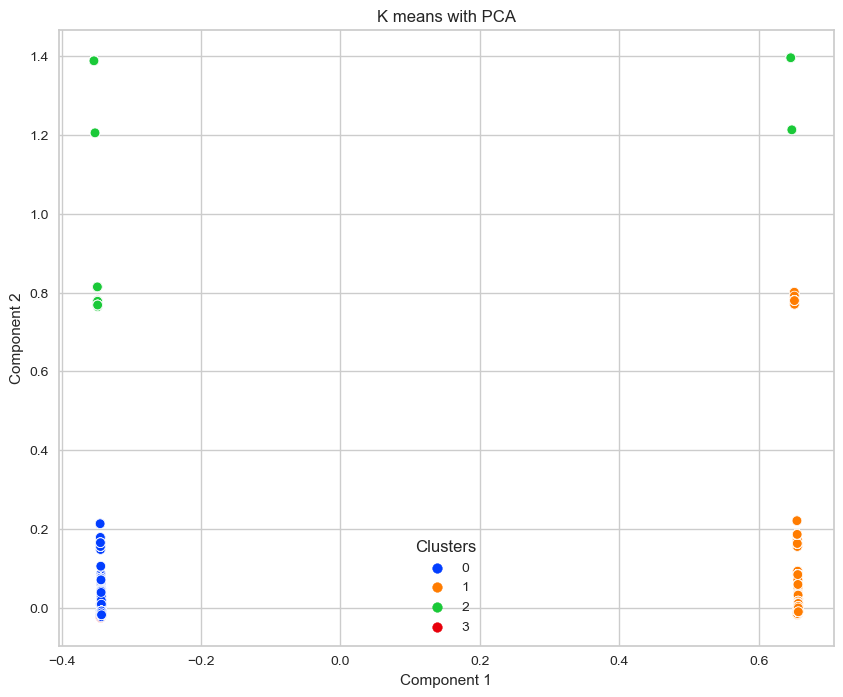

In [ ]:
x_axis = df_segm_pca_means2['Component 1']
y_axis = df_segm_pca_means2['Component 2']
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=x_axis, y=y_axis, hue=df_segm_pca_means2['Clusters'], palette="bright")
plt.title("K means with PCA")
plt.show()

#### Important columns

In [ ]:
a = list(all_data2.columns)
try:
    a.remove('index')
except:
    a = list(all_data2.columns)

clust_check2 = df_segm_pca_means2.groupby(['Clusters']).mean()
clust_checks2 = clust_check2[a]
print(clust_checks2.shape)
clust_checks2

(4, 10)


price  calculated_host_listings_count  host_name_andrew  \
Clusters                                                               
0         0.014653                        0.007052          0.003985   
1         0.013180                        0.006538          0.003541   
2         0.025119                        0.727811          0.000000   
3         0.012812                        0.001641          0.000000   

          host_name_jennifer  host_name_melissa  host_name_mike  \
Clusters                                                          
0                   0.003428           0.003786        0.004185   
1                   0.003014           0.003842        0.003993   
2                   0.000000           0.000000        0.000000   
3                   0.000000           0.000000        0.000000   

          host_name_rachel  host_name_sarah  neighbourhood_Other  \
Clusters                                                           
0                 0.003667         0.000000             0.000000   
1                 0.002185         0.003767             1.000000   
2                 0.000000         0.000000             0.128527   
3                 0.000000         1.000000             0.000000   

          gender_Company  
Clusters                  
0               0.000000  
1               0.002712  
2               1.000000  
3               0.000000

In [ ]:
for name in a:

    mean_val = np.mean(clust_checks2[name])
    clust_checks2[str('Index_') + str(name)] = (clust_checks2[name]/mean_val) * 100


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
import_col2 = []
index_col = [col for col in clust_checks2 if col.startswith('Index')]
for name in index_col:
    if ((min(clust_checks2[name]) < 60) | (max(clust_checks2[name]) > 250)) & (min(clust_checks2[name]) != 0):
        import_col2.append(name)

print(len(import_col2), import_col2)


1 ['Index_calculated_host_listings_count']


In [ ]:
clust_checks3 = clust_checks2.sort_values(by='price')
clust_checks3[index_col]

Index_price  Index_calculated_host_listings_count  \
Clusters                                                      
3           77.925286                              0.883260   
1           80.165758                              3.519721   
0           89.126625                              3.796154   
2          152.782330                            391.800865   

          Index_host_name_andrew  Index_host_name_jennifer  \
Clusters                                                     
3                       0.000000                  0.000000   
1                     188.189232                187.148679   
0                     211.810768                212.851321   
2                       0.000000                  0.000000   

          Index_host_name_melissa  Index_host_name_mike  \
Clusters                                                  
3                        0.000000              0.000000   
1                      201.472579            195.311747   
0                      198.527421            204.688253   
2                        0.000000              0.000000   

          Index_host_name_rachel  Index_host_name_sarah  \
Clusters                                                  
3                       0.000000             398.498837   
1                     149.354639               1.501163   
0                     250.645361               0.000000   
2                       0.000000               0.000000   

          Index_neighbourhood_Other  Index_gender_Company  
Clusters                                                   
3                          0.000000              0.000000  
1                        354.444444              1.081975  
0                          0.000000              0.000000  
2                         45.555556            398.918025

### Models

#### Gradient Boosting Regressor

In [ ]:
gbr = GradientBoostingRegressor(random_state=0)

In [ ]:
GradientBoostingRegressor().get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [ ]:
gbr_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}

gbr_gridsearch = GridSearchCV(gbr, gbr_param_grid, cv = 5, verbose = 2)

gbr_gridsearch.fit(X_train, y_train)

print("Best parameters: ", gbr_gridsearch.best_params_)
# Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
print("Cross Validation Score: ", gbr_gridsearch.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.0s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.9s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.2s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.9s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.0s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total ti

KeyboardInterrupt: ignored

In [ ]:
gbr_hyp = GradientBoostingRegressor(random_state=0,
                                    learning_rate = gbr_gridsearch.best_params_['learning_rate'],
                                    n_estimators = gbr_gridsearch.best_params_['n_estimators'],
                                    max_depth = gbr_gridsearch.best_params_['max_depth'],
                                    min_samples_split = gbr_gridsearch.best_params_['min_samples_split'],
                                    min_samples_leaf = gbr_gridsearch.best_params_['min_samples_leaf'])

In [ ]:
gbr_valid_score = gbr_gridsearch.score(X_test, y_test)

print("Validation Score: ", gbr_valid_score)

gbr_hyp.fit(X_train, y_train)

y_pred_gbr = gbr_hyp.predict(X_test)

gbr_mae = mean_absolute_error(y_test, y_pred_gbr)
print("MAE: ", gbr_mae)
# MAE:  2.230827876694104

gbr_rmse = mean_squared_error(y_test, y_pred_gbr, squared=False)
print("RMSE: ", gbr_rmse)
# RMSE:  3.1949612716361906

print("R2 score: ", r2_score(y_test, y_pred_gbr))

#### Adaboost Regressor

In [ ]:
AdaBoostRegressor().get_params().keys()

dict_keys(['base_estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'])

In [ ]:
abr = AdaBoostRegressor()

abr_param_grid = {
    'learning_rate': [0.4, 0.2, 0.1, 0.05, 0.01],
    'n_estimators': [50, 100, 200, 300, 400],
    'loss' : ['linear', 'square', 'exponential']
}

abr_gridsearch = GridSearchCV(abr, abr_param_grid, cv = 3, verbose = 2)

abr_gridsearch.fit(X_train, y_train)

print("Best parameters: ", abr_gridsearch.best_params_)
# Best parameters:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 50}
# Cross Validation Score:  0.07744818634601136
print("Cross Validation Score: ", abr_gridsearch.best_score_)

Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV] END ....learning_rate=0.4, loss=linear, n_estimators=50; total time=   4.4s
[CV] END ....learning_rate=0.4, loss=linear, n_estimators=50; total time=   5.5s
[CV] END ....learning_rate=0.4, loss=linear, n_estimators=50; total time=   4.6s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=100; total time=   3.8s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=100; total time=   4.8s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=100; total time=   3.9s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=200; total time=   5.1s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=200; total time=   2.9s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=200; total time=   5.0s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=300; total time=   3.8s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=300; total time=   5.6s
[CV] END ...learning_rate=0.4, loss=linear, n_e

[CV] END ...learning_rate=0.1, loss=linear, n_estimators=300; total time=  11.2s
[CV] END ...learning_rate=0.1, loss=linear, n_estimators=300; total time=   9.8s
[CV] END ...learning_rate=0.1, loss=linear, n_estimators=400; total time=  17.2s
[CV] END ...learning_rate=0.1, loss=linear, n_estimators=400; total time=  10.9s
[CV] END ...learning_rate=0.1, loss=linear, n_estimators=400; total time=  14.5s
[CV] END ....learning_rate=0.1, loss=square, n_estimators=50; total time=   5.5s
[CV] END ....learning_rate=0.1, loss=square, n_estimators=50; total time=   5.5s
[CV] END ....learning_rate=0.1, loss=square, n_estimators=50; total time=   5.7s
[CV] END ...learning_rate=0.1, loss=square, n_estimators=100; total time=  10.7s
[CV] END ...learning_rate=0.1, loss=square, n_estimators=100; total time=  10.7s
[CV] END ...learning_rate=0.1, loss=square, n_estimators=100; total time=  10.6s
[CV] END ...learning_rate=0.1, loss=square, n_estimators=200; total time=  21.4s
[CV] END ...learning_rate=0.

[CV] END ..learning_rate=0.01, loss=square, n_estimators=200; total time=  23.3s
[CV] END ..learning_rate=0.01, loss=square, n_estimators=200; total time=  22.7s
[CV] END ..learning_rate=0.01, loss=square, n_estimators=200; total time=  22.6s
[CV] END ..learning_rate=0.01, loss=square, n_estimators=300; total time=  33.7s
[CV] END ..learning_rate=0.01, loss=square, n_estimators=300; total time=  33.9s
[CV] END ..learning_rate=0.01, loss=square, n_estimators=300; total time=  33.7s
[CV] END ..learning_rate=0.01, loss=square, n_estimators=400; total time=  44.4s
[CV] END ..learning_rate=0.01, loss=square, n_estimators=400; total time=  44.9s
[CV] END ..learning_rate=0.01, loss=square, n_estimators=400; total time=  45.1s
[CV] END learning_rate=0.01, loss=exponential, n_estimators=50; total time=   5.6s
[CV] END learning_rate=0.01, loss=exponential, n_estimators=50; total time=   5.9s
[CV] END learning_rate=0.01, loss=exponential, n_estimators=50; total time=   5.7s
[CV] END learning_rate

In [ ]:
abr_hyp = AdaBoostRegressor(random_state=0,
                            learning_rate = abr_gridsearch.best_params_['learning_rate'],
                            n_estimators = abr_gridsearch.best_params_['n_estimators'],
                            loss = abr_gridsearch.best_params_['loss'])

In [ ]:
abr_valid_score = abr_gridsearch.score(X_test, y_test)

print("Validation Score: ", abr_valid_score)
# Validation Score:  0.1195960678230149

abr_hyp.fit(X_train, y_train)

y_pred_abr = abr_hyp.predict(X_test)

abr_mae = mean_absolute_error(y_test, y_pred_abr)
print("MAE: ", abr_mae)
# MAE:  71.79626747527546

abr_rmse = mean_squared_error(y_test, y_pred_abr, squared=False)
print("RMSE: ", abr_rmse)
# RMSE:  218.55941440071533

print("R2 score: ", r2_score(y_test, y_pred_abr))
# R2 score:  0.1211632427225472

Validation Score:  0.1195960678230149
MAE:  71.79626747527546
RMSE:  218.55941440071533
R2 score:  0.1211632427225472


#### Light GBM Regressor

In [ ]:
lg.LGBMRegressor().get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [ ]:
lgb = lg.LGBMRegressor()

lgb_param_grid = {
    'num_leaves' : [60, 100, 200],
    'min_data_in_leaf': [50, 100, 500],
    'max_bin' : [200, 300, 500],
    'learning_rate': [0.2, 0.1, 0.01, 0.001],
    'max_depth': [5, 7, 9],
    'n_estimators': [100, 200, 400]
}

lgb_gridsearch = GridSearchCV(lgb, lgb_param_grid, cv = 5, verbose = 2)

lgb_gridsearch.fit(X_train, y_train)

print("Best parameters: ", lgb_gridsearch.best_params_)

Best parameters:  {'learning_rate': 0.1, 'max_bin': 500, 'max_depth': 7, 'min_data_in_leaf': 100, 'n_estimators': 100, 'num_leaves': 100}
Cross Validation Score:  0.13607427645893372

print("Cross Validation Score: ", lgb_gridsearch.best_score_)

Streaming output truncated to the last 5000 lines.
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_s

In [ ]:
lgb_hyp = lg.LGBMRegressor(random_state=0,
                            num_leaves = lgb_gridsearch.best_params_['num_leaves'],
                            min_data_in_leaf = lgb_gridsearch.best_params_['min_data_in_leaf'],
                            max_bin = lgb_gridsearch.best_params_['max_bin'],
                            learning_rate = lgb_gridsearch.best_params_['learning_rate'],
                            n_estimators = lgb_gridsearch.best_params_['n_estimators'],
                            max_depth = lgb_gridsearch.best_params_['max_depth'])

In [ ]:
lgb_valid_score = lgb_gridsearch.score(X_test, y_test)

print("Validation Score: ", lgb_valid_score)
# Validation Score:  0.9092250766806657

lgb_hyp.fit(X_train, y_train)

y_pred_lgb = lgb_hyp.predict(X_test)

lgb_mae = mean_absolute_error(y_test, y_pred_lgb)
print("MAE: ", lgb_mae)
# MAE:  1.9961167535661593

lgb_rmse = mean_squared_error(y_test, y_pred_lgb, squared=False)
print("RMSE: ", lgb_rmse)
# RMSE:  2.820238676253174

print("R2 score: ", r2_score(y_test, y_pred_lgb))
# R2 score:  0.9092250766806657

Validation Score:  0.0433622540328249
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
MAE:  95.57204239446854
RMSE:  228.02851988341948
R2 score:  0.0433622540328249


#### Random Forest Regressor

In [ ]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [ ]:
rfr = RandomForestRegressor(random_state=0, n_jobs=-1)

rfr_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 9],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2']
}

rfr_gridsearch = GridSearchCV(rfr, rfr_param_grid, cv=3, verbose = 2)

rfr_gridsearch.fit(X_train, y_train)

print("Best parameters: ", rfr_gridsearch.best_params_)

# Best parameters:  {'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 200}
# Cross Validation Score:  0.10538253242185136
print("Cross Validation Score: ", rfr_gridsearch.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   5.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   5.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   6.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   5.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   6.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=200; total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=200; total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=200; total time=  10.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=50; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=50; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=50; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time=   4.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200; total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200; total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200; total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50; total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100; total time=   6.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200; total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200; total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200; total time=   9.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END max_depth=5, max_features=sqrt, min_sample

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   6.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  12.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  12.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  12.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=  11.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=  12.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   5.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=  12.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=  12.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=  12.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  12.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  13.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  12.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   5.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=  12.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=  11.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=  11.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   6.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   6.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   5.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=  12.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=  12.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=  12.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=200; total time=  12.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=200; total time=  12.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=200; total time=  12.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200; total time=  12.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200; total time=  11.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200; total time=  12.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50; total time=   4.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100; total time=   5.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100; total time=   6.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200; total time=  12.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200; total time=  12.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200; total time=  12.6s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   3.7s
[CV] END max_depth=7, max_features=sqrt, min_sample

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   5.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  15.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  15.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  14.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   4.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=  15.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=  16.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=  15.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=  15.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=  15.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=  15.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  14.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  15.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  15.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   6.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=  15.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=  16.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=  15.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   6.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=  14.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=  15.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=  15.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   6.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=200; total time=  15.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=200; total time=  15.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=200; total time=  15.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=50; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=50; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=50; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=100; total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200; total time=  14.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200; total time=  14.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200; total time=  14.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100; total time=   6.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100; total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100; total time=   6.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200; total time=  15.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200; total time=  15.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200; total time=  15.3s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.5s
[CV] END max_depth=9, max_features=sqrt, min_sample

In [ ]:
rfr_hyp = RandomForestRegressor(random_state=0,
                                max_depth = rfr_gridsearch.best_params_['max_depth'],
                                max_features = rfr_gridsearch.best_params_['max_features'],
                                min_samples_leaf = rfr_gridsearch.best_params_['min_samples_leaf'],
                                min_samples_split = rfr_gridsearch.best_params_['min_samples_split'],
                                n_estimators = rfr_gridsearch.best_params_['n_estimators'])

In [ ]:
rfr_valid_score = rfr_gridsearch.score(X_test, y_test)

print("Validation Score: ", rfr_valid_score)
# Validation Score:  0.13891619560381208

rfr_hyp.fit(X_train, y_train)

y_pred_rfr = rfr_hyp.predict(X_test)

rfr_mae = mean_absolute_error(y_test, y_pred_rfr)
print("MAE: ", rfr_mae)
# MAE:  72.77285299768388

rfr_rmse = mean_squared_error(y_test, y_pred_rfr, squared=False)
print("RMSE: ", rfr_rmse)
# RMSE:  216.3406460817012

print("R2 score: ", r2_score(y_test, y_pred_rfr))
# R2 score:  0.13891619560381208

Validation Score:  0.13891619560381208
MAE:  72.77285299768388
RMSE:  216.3406460817012
R2 score:  0.13891619560381208


#### XGB Regressor

In [ ]:
xg.XGBRegressor().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [ ]:
xgb = xg.XGBRegressor(random_state=0, n_jobs=-1)

xgb_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 5, 7],
    'max_bin' : [50, 100, 300],
    'min_child_weight': [3, 5, 7]
}

xgb_gridsearch = GridSearchCV(xgb, xgb_param_grid, cv = 3, verbose = 2)

xgb_gridsearch.fit(X_train, y_train)

print("Best parameters: ", xgb_gridsearch.best_params_)
print("Cross Validation Score: ", xgb_gridsearch.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=200; total time=  17.4s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=200; total time=  13.0s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=200; total time=  14.7s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=300; total time=  27.0s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=300; total time=  21.7s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=300; total time=  27.5s
[CV] END learning_rate=0.1, max_bin=50, max_depth=3, min_child_weight=3, n_estimators=400; total time=  50.7s


In [ ]:
xgb_hyp = xg.XGBRegressor(random_state=0,
                          max_depth = xgb_gridsearch.best_params_['max_depth'],
                          learning_rate = xgb_gridsearch.best_params_['learning_rate'],
                          max_bin = xgb_gridsearch.best_params_['max_bin'],
                          min_child_weight = xgb_gridsearch.best_params_['min_child_weight'],
                          n_estimators = xgb_gridsearch.best_params_['n_estimators'])

In [ ]:
xgb_valid_score = xgb_gridsearch.score(X_test, y_test)

print("Validation Score: ", xgb_valid_score)

xgb_hyp.fit(X_train, y_train)

y_pred_xgb = xgb_hyp.predict(X_test)

xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
print("MAE: ", xgb_mae)

xgb_rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("RMSE: ", xgb_rmse)

print("R2 score: ", r2_score(y_test, y_pred_xgb))

#### Neural network

In [49]:
n_inputs = X_train.shape[1]

nn_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(20, activation='relu'),
    Dense(15, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])

In [50]:
nn_model.compile(Adam(learning_rate = 0.0001), loss = 'mse')

In [51]:
history = nn_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=100, shuffle=True, verbose=2, validation_data=(X_test, y_test))

Epoch 1/100
1564/1564 - 5s - loss: 63102.1016 - val_loss: 49813.3516 - 5s/epoch - 3ms/step
Epoch 2/100
1564/1564 - 5s - loss: 53118.9414 - val_loss: 48300.3359 - 5s/epoch - 3ms/step
Epoch 3/100
1564/1564 - 4s - loss: 52468.3125 - val_loss: 47817.8867 - 4s/epoch - 2ms/step
Epoch 4/100
1564/1564 - 3s - loss: 52180.6172 - val_loss: 47600.7305 - 3s/epoch - 2ms/step
Epoch 5/100
1564/1564 - 4s - loss: 52029.1641 - val_loss: 47470.9336 - 4s/epoch - 2ms/step
Epoch 6/100
1564/1564 - 5s - loss: 51902.5039 - val_loss: 47418.5820 - 5s/epoch - 3ms/step
Epoch 7/100
1564/1564 - 5s - loss: 51803.7969 - val_loss: 47318.1953 - 5s/epoch - 3ms/step
Epoch 8/100
1564/1564 - 4s - loss: 51723.6133 - val_loss: 47298.3867 - 4s/epoch - 2ms/step
Epoch 9/100
1564/1564 - 6s - loss: 51657.9961 - val_loss: 47219.3008 - 6s/epoch - 4ms/step
Epoch 10/100
1564/1564 - 4s - loss: 51583.0586 - val_loss: 47213.7695 - 4s/epoch - 2ms/step
Epoch 11/100
1564/1564 - 3s - loss: 51526.4883 - val_loss: 47205.9766 - 3s/epoch - 2ms/st

In [52]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

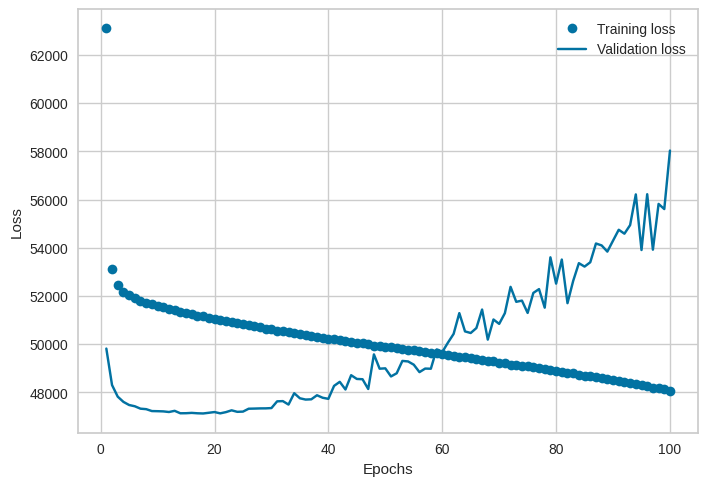

In [53]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
y_pred_nn = nn_model.predict(X_test, batch_size=200, verbose=0)

In [55]:
nn_mae = mean_absolute_error(y_test, y_pred_nn)
print("MAE: ", nn_mae)

nn_rmse = mean_squared_error(y_test, y_pred_nn, squared=False)
print("RMSE: ", nn_rmse)

print("R2 score: ", r2_score(y_test, y_pred_nn))

MAE:  102.6030142857328
RMSE:  240.90142280327711
R2 score:  -0.06769671434294056


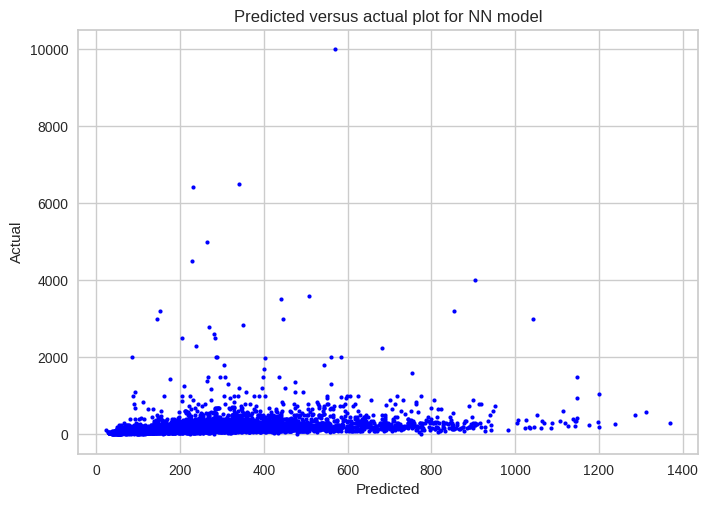

In [56]:
plt.plot(y_pred_nn, y_test, 'o', color='blue', markersize=3)
plt.title('Predicted versus actual plot for NN model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show();

In [57]:
n_inputs = X_train.shape[1]

nn_model_tanh = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(15, activation='tanh'),
    Dense(10, activation='tanh'),
    Dense(1)
])

In [58]:
nn_model_tanh.compile(optimizer="adam", loss="mse")

trained_model_tanh = nn_model_tanh.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=100, shuffle=True, verbose=2, validation_data=(X_test, y_test))

y_pred_tanh = nn_model_tanh.predict(X_test)

Epoch 1/100
1564/1564 - 5s - loss: 78116.1016 - val_loss: 71985.1797 - 5s/epoch - 3ms/step
Epoch 2/100
1564/1564 - 3s - loss: 73900.0078 - val_loss: 68145.0312 - 3s/epoch - 2ms/step
Epoch 3/100
1564/1564 - 4s - loss: 70377.8281 - val_loss: 64910.1289 - 4s/epoch - 2ms/step
Epoch 4/100
1564/1564 - 4s - loss: 67424.6797 - val_loss: 62194.2773 - 4s/epoch - 3ms/step
Epoch 5/100
1564/1564 - 3s - loss: 64936.6523 - val_loss: 59938.5938 - 3s/epoch - 2ms/step
Epoch 6/100
1564/1564 - 3s - loss: 62935.1445 - val_loss: 58172.2070 - 3s/epoch - 2ms/step
Epoch 7/100
1564/1564 - 4s - loss: 61421.9688 - val_loss: 56860.7695 - 4s/epoch - 2ms/step
Epoch 8/100
1564/1564 - 5s - loss: 60295.7305 - val_loss: 55907.6289 - 5s/epoch - 3ms/step
Epoch 9/100
1564/1564 - 3s - loss: 59515.0938 - val_loss: 55267.2539 - 3s/epoch - 2ms/step
Epoch 10/100
1564/1564 - 3s - loss: 58999.7656 - val_loss: 54862.1289 - 3s/epoch - 2ms/step
Epoch 11/100
1564/1564 - 4s - loss: 58689.9609 - val_loss: 54626.1719 - 4s/epoch - 3ms/st

In [59]:
nn_mae_tanh = mean_absolute_error(y_test, y_pred_tanh)
print("MAE: ", nn_mae_tanh)

nn_rmse_tanh = mean_squared_error(y_test, y_pred_tanh, squared=False)
print("RMSE: ", nn_rmse_tanh)

print("R2 score: ", r2_score(y_test, y_pred_tanh))

MAE:  92.49631837436829
RMSE:  233.1398003414643
R2 score:  -4.643486177569045e-06


#### Hyperparameter model

In [72]:
print(X_train.shape, y_train.shape)

(39082, 75) (39082,)


In [73]:
a = list(X_train.columns)
a.sort()
print(a)

['availability_365', 'calculated_host_listings_count', 'feature_10', 'feature_11', 'feature_2', 'feature_3', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'host_name_Other', 'host_name_alex', 'host_name_andrew', 'host_name_anna', 'host_name_blueground', 'host_name_chris', 'host_name_daniel', 'host_name_david', 'host_name_emily', 'host_name_james', 'host_name_jennifer', 'host_name_jessica', 'host_name_john', 'host_name_kara', 'host_name_laura', 'host_name_maria', 'host_name_melissa', 'host_name_michael', 'host_name_mike', 'host_name_sarah', 'host_name_sonder_(nyc)', 'minimum_nights', 'neighbourhood_Astoria', 'neighbourhood_Bedford_Stuyvesant', 'neighbourhood_Bushwick', 'neighbourhood_Chelsea', 'neighbourhood_Clinton_Hill', 'neighbourhood_Crown_Heights', 'neighbourhood_East_Harlem', 'neighbourhood_East_Village', 'neighbourhood_Financial_District', 'neighbourhood_Flatbush', 'neighbourhood_Greenpoint', 'neighbourhood_Harlem', 'neighbourhood_Hells_Kitchen', 'neighbourhood

In [52]:
input_shape = (X_train.shape[1],)
hypermodel = RegressionHyperModel(input_shape)

In [53]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2)

In [54]:
tuner_rs.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [55]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
loss, mse = best_model.evaluate(X_test, y_test)

ValueError: ignored

In [79]:
y_pred_hyp = best_model.predict(X_test)

nn_mae_hyp = mean_absolute_error(y_test, y_pred_hyp)
print("MAE: ", nn_mae_hyp)

nn_rmse_hyp = mean_squared_error(y_test, y_pred_hyp, squared=False)
print("RMSE: ", nn_rmse_hyp)

print("R2 score: ", r2_score(y_test, y_pred_hyp))

NameError: ignored


#### Bayesian optimisation



In [84]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)

In [44]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='mse',
            max_trials=10,
            seed=42,
            executions_per_trial=2
        )
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

best_model_bo = tuner_bo.get_best_models(num_models=1)[0]
best_model_bo.evaluate(X_test, y_test)

RuntimeError: ignored

In [45]:
y_pred_bo = best_model_bo.predict(X_test)

nn_mae_bo = mean_absolute_error(y_test, y_pred_bo)
print("MAE: ", nn_mae_bo)

nn_rmse_bo = mean_squared_error(y_test, y_pred_bo, squared=False)
print("RMSE: ", nn_rmse_bo)

print("R2 score: ", r2_score(y_test, y_pred_hyp))

NameError: ignored

In [48]:
tuner_hb = Hyperband(
            hypermodel,
            max_epochs=5,
            objective='mse',
            seed=42,
            executions_per_trial=2
        )
tuner_hb.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)
best_model = tuner_hb.get_best_models(num_models=1)[0]
best_model.evaluate(x_test_scaled, y_test)

RuntimeError: ignored

### Residuals

In [ ]:
residual = y_test - y_pred_gbr
y_preds = pd.Series(y_pred_gbr)
y_preds.index = range(0,len(y_preds))
residual.index = range(0,len(residual))
a = pd.concat([residual,y_preds],axis=1,ignore_index=True)
resid_data = pd.DataFrame(a)
resid_data.columns = ['Residuals','Predicted']
plt.plot(resid_data['Residuals'], 'o', color='blue', markersize=3)
plt.title('Residual plot for model')
plt.ylabel('Residuals')
plt.show()

In [ ]:
ax = sns.jointplot(x=resid_data['Predicted'], y=resid_data['Residuals'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
ax.ax_joint.set_xlabel('Predicted', fontweight='bold')
ax.ax_joint.set_ylabel('Residuals', fontweight='bold')
plt.show()

In [ ]:
stats.probplot(resid_data['Residuals'], dist="norm", plot=pylab)
pylab.show()

### Shapley values

In [ ]:
gbr_hyp.fit(X_train, y_train);

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(gbr_hyp)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.initjs()


In [ ]:
shap_values = shap.TreeExplainer(gbr_hyp).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_train)